In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.table import Table
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNextractor, PSF_residuals
from ppxf import robust_sigma
%config InlineBackend.figure_format = 'retina'

/local/tspriggs/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# functions
# Open Fits file and assign to raw_data
hdulist = fits.open("FCC167_data/FCC167_OIII_line_center.fits")
hdr = hdulist[0].header
raw_data = hdulist[0].data
y_data = hdr["NAXIS2"]
x_data = hdr["NAXIS1"]
wavelength = np.exp(hdr['CRVAL3']+np.arange(hdr["NAXIS3"])*hdr['CDELT3'])
# swap axes to y,x,wavelength
raw_data_list = np.array(raw_data).reshape(len(wavelength), x_data*y_data)
raw_data_list = np.swapaxes(raw_data_list, 1, 0)
# Check for nan values
raw_data_cube = raw_data_list.reshape(y_data, x_data, len(wavelength))

#Read in x and y coordinates
x_y_list = np.load("exported_data/FCC167/sep_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

n_pixels= 13
z = 0.006261
c = 299792458.0

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

flatten = lambda l: [item for sublist in l for item in sublist]

# Retrieve the respective spectra for each PNe source
PNe_spectra = np.array([PNextractor(x, y, n_pixels, raw_data_cube, wave=wavelength, dim=2.0) for x,y in zip(x_PNe, y_PNe)])

# create Pandas data frame for values
PNe_df = pd.DataFrame(columns=("PNe number", "Total Flux", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN", "rad D"))
PNe_df["PNe number"] = np.arange(1,len(x_PNe)+1) # PNe numbers
PNe_df["rad D"] = [np.sqrt((x-x_data/2.)**2 + (y - y_data/2.)**2) for x,y in zip(x_PNe, y_PNe)] # Radial distance, in pixels, from the centre of pointing
# .loc(Row, column name)

# Objective Residual Cube
obj_residual_cube = np.load("exported_data/FCC167/list_of_resids_min_obj.npy")
obj_residual_cube[obj_residual_cube==np.inf] = 0.01
obj_residual_cube_shape = obj_residual_cube.reshape(y_data, x_data, len(wavelength))
PNe_uncertainty = np.array([PNextractor(x, y, n_pixels, obj_residual_cube_shape, wave=wavelength, dim=2) for x,y in zip(x_PNe, y_PNe)])

obj_error_cube = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))

for p in np.arange(0, len(x_PNe)):
    list_of_std = [np.abs(np.std(spec)) for spec in PNe_uncertainty[p]]
    obj_error_cube[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]

# Data Residual Cube
residual_cube = np.load("exported_data/FCC167/list_of_resids_min.npy")
residual_cube[residual_cube==np.inf] = 0.01
residual_cube_shape = residual_cube.reshape(y_data, x_data, len(wavelength))
PNe_uncertainty = np.array([PNextractor(x, y, n_pixels, residual_cube_shape, wave=wavelength, dim=2) for x,y in zip(x_PNe, y_PNe)])

error_cube = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))

for p in np.arange(0, len(x_PNe)):
    list_of_std = [np.abs(np.std(spec)) for spec in PNe_uncertainty[p]]
    error_cube[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]

In [44]:
def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    data_shape = data.reshape(y_data, x_data, len(wavelength))
    extract_data = np.array([PNextractor(x, y, n_pix, data_shape, wave=wavelength, dim=2) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = [np.abs(np.std(spec)) for spec in extract_data[p]]
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(residual_cube, x_PNe, y_PNe, n_pixels)

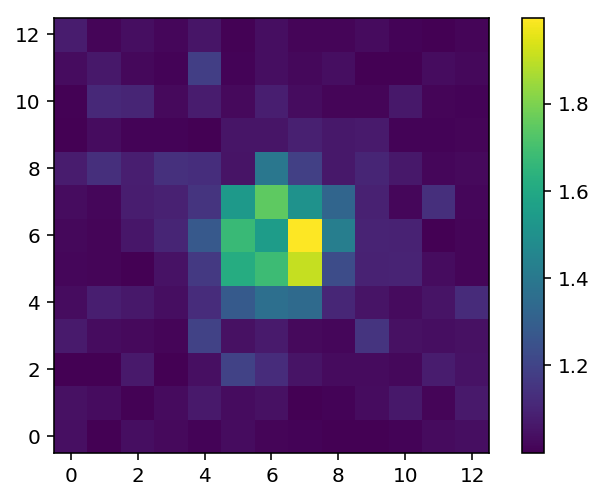

In [11]:
plt.imshow(1/obj_error_cube[17][:,0].reshape(n_pixels,n_pixels), origin="lower")
plt.colorbar()

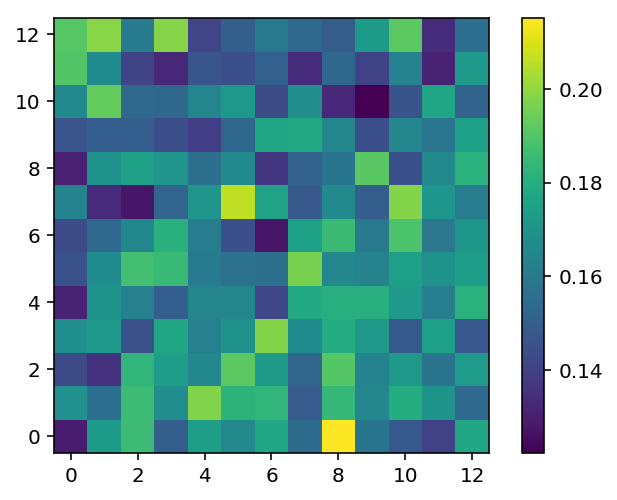

In [45]:
plt.imshow(1/error_cube[17][:,0].reshape(n_pixels,n_pixels), origin="lower")
plt.colorbar()

# 3D fitting routine

$$ f(x,y) = A \Big(1+ \frac{(x - x_0)^2 + (y - y_0)^2}{\gamma^2}\Big)^{-\beta} $$

In [3]:
# Parameter setup

PNe_params = Parameters()
PNe_params.add('Amp_2D', value=100., min=0.01)
#PNe_params.add("Amp_2", value=20, min=0.01)
PNe_params.add('x_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_params.add('y_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_params.add("M_FWHM", value=3.6, vary=False)
#PNe_params.add("G_FWHM", value=3., min=0.1,  vary=True) # Signal
#PNe_params.add("G_FWHM_2", value=8.,min=0.1, vary=True) # Noise - Set FWHM to higher value to control which Gauss model is signal and which is noise
PNe_params.add("beta", value=2.7, vary=False) #1.46
PNe_params.add("mean", value=5035., min=5000., max=5070.)
PNe_params.add("Gauss_bkg",  value=0.001)
PNe_params.add("Gauss_grad", value=0.001)

FWHM_in_err = 0.2921
beta_in_err = 0.7567

#4.7863813596549436
#2.2710857136431621


#3.477154047381648
#2.545797591806868

## Fitting routine

FloatProgress(value=0.0, description='Fitting progress', max=76.0)

26.855654648376003


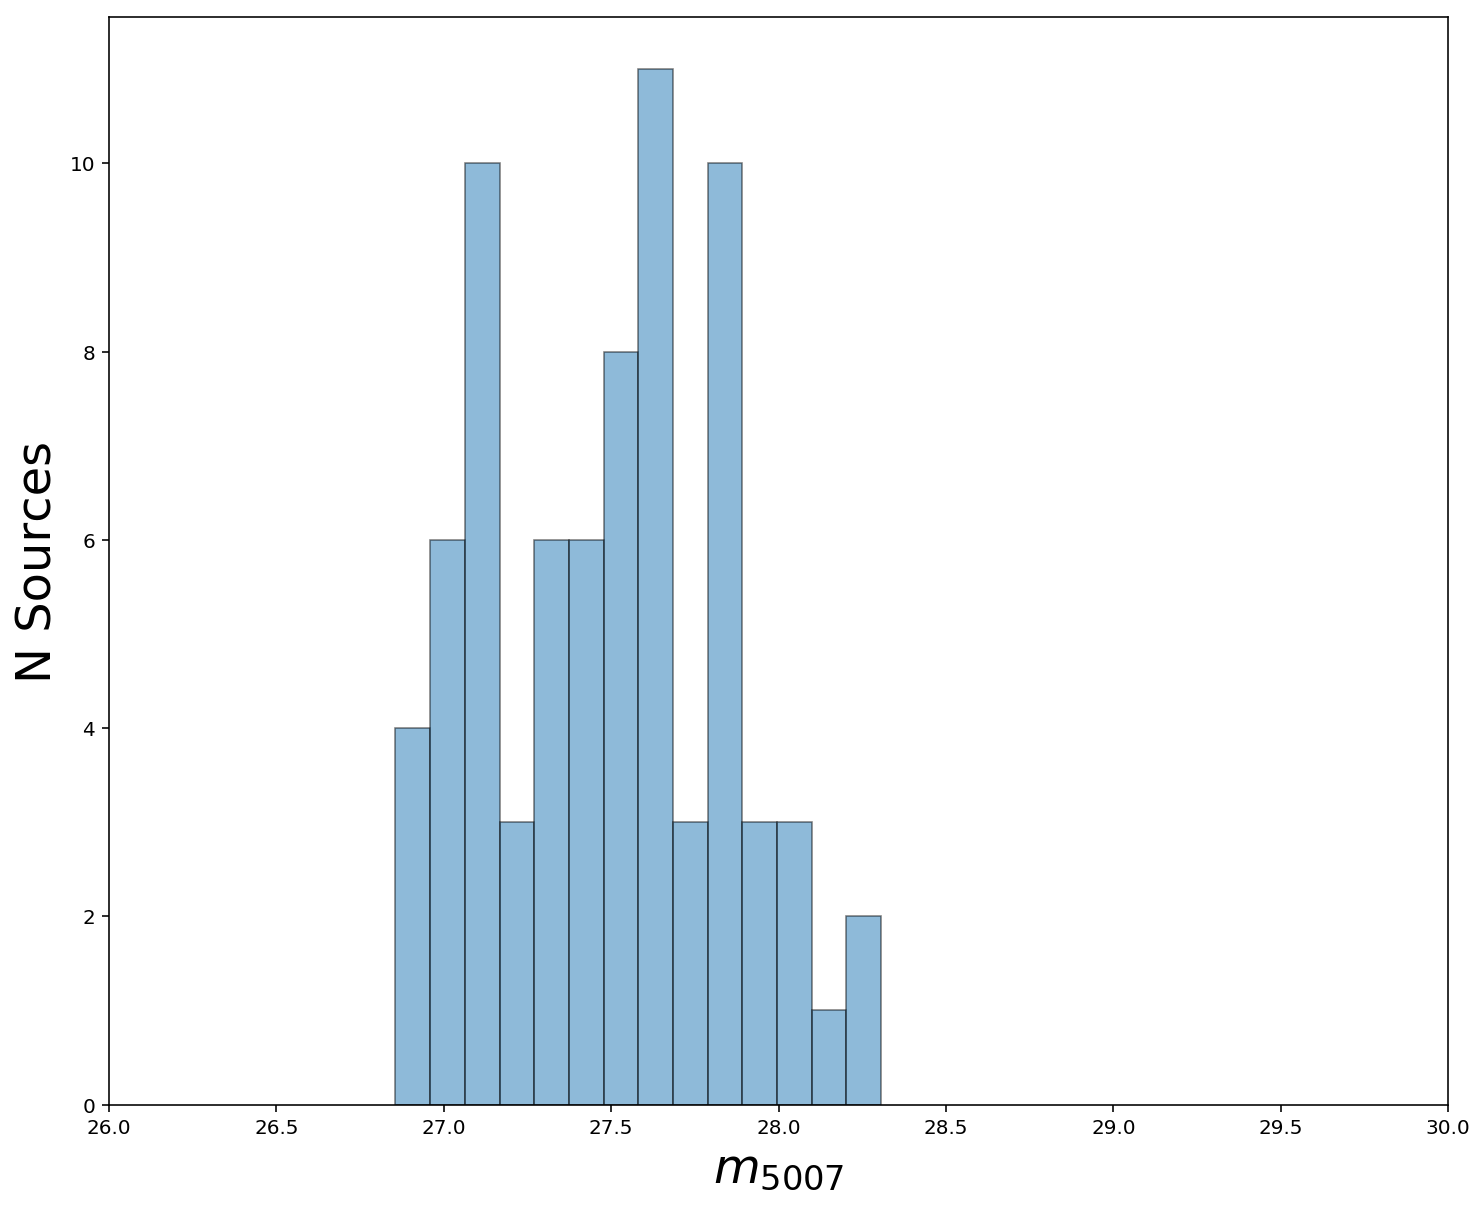

In [20]:
# useful value storage setup
total_Flux = np.zeros(len(x_PNe))
residuals_list = np.zeros(len(x_PNe))
A_OIII_list = np.zeros(len(x_PNe))
F_OIII_xy_list = np.zeros((len(x_PNe), len(PNe_spectra[0])))
M_amp_list = np.zeros(len(x_PNe))
mean_wave_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))

# error lists
moff_A_err = np.zeros(len(x_PNe))
x_0_err = np.zeros(len(x_PNe))
y_0_err = np.zeros(len(x_PNe))
mean_wave_err = np.zeros(len(x_PNe))
Gauss_bkg_err = np.zeros(len(x_PNe))
Gauss_grad_err = np.zeros(len(x_PNe))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

model_2D = "Moffat"
#model_2D = "Gauss"
#model_2D = "Gauss_2"

f = FloatProgress(min=0, max=len(x_PNe), description="Fitting progress", )
display(f)

for PNe_num in np.arange(0, len(x_PNe)):
    useful_stuff = []
    #run minimizer fitting routine
    fit_results = minimize(MUSE_3D_residual, PNe_params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], model_2D, PNe_num, useful_stuff), nan_policy="propagate")
    # Store values in numpy arrays
    if model_2D == "Moffat" or model_2D == "Gauss":
        PNe_df.loc[PNe_num, "Total Flux"] = np.sum(useful_stuff[1][1]) * 1e-20
    if model_2D == "Gauss_2":
        PNe_df.loc[PNe_num, "Total Flux"] = (np.sum(useful_stuff[1][2]) + (0.68 * np.sum(useful_stuff[1][3]))) * 1e-20
    list_of_fit_residuals[PNe_num] = useful_stuff[0]
    A_OIII_list[PNe_num] = useful_stuff[1][0]
    F_OIII_xy_list[PNe_num] = useful_stuff[1][1]
    M_amp_list[PNe_num] = fit_results.params["Amp_2D"]
    list_of_x[PNe_num] = fit_results.params["x_0"]
    list_of_y[PNe_num] = fit_results.params["y_0"]
    mean_wave_list[PNe_num] = fit_results.params["mean"]
    Gauss_bkg[PNe_num] = fit_results.params["Gauss_bkg"]
    Gauss_grad[PNe_num] = fit_results.params["Gauss_grad"]
    #save errors
    moff_A_err[PNe_num] = fit_results.params["Amp_2D"].stderr
    x_0_err[PNe_num] = fit_results.params["x_0"].stderr
    y_0_err[PNe_num] = fit_results.params["y_0"].stderr
    mean_wave_err[PNe_num] = fit_results.params["mean"].stderr
    Gauss_bkg_err[PNe_num] = fit_results.params["Gauss_bkg"].stderr
    Gauss_grad_err[PNe_num] = fit_results.params["Gauss_grad"].stderr
    f.value+=1.

#Apply circular aperture to total flux
#Y_circ, X_circ = np.mgrid[:n_pixels, :n_pixels]
##if model_2D == "Moffat":
#r = PNe_params["M_FWHM"]
## elif model_2D == "Gauss":
##     r = round(0.75* PNe_params["G_FWHM"])
## elif model_2D == "Gauss_2":
##     r = round(0.75* np.abs(PNe_params["G_FWHM_2"]))
#for i in np.arange(0, len(x_PNe)):
#    circ_mask = (Y_circ-list_of_y[i])**2 + (X_circ-list_of_x[i])**2 > r*r
#    flux_n = np.array(F_OIII_xy_list[i]) # copy list of fluxes
#    flux_2D = flux_n.reshape(n_pixels, n_pixels) #reshape
#    flux_2D[circ_mask==True] = 0.0 # set mask = False areas to 0.0
#    PNe_df.loc[i, "Total Flux"] = np.sum(flux_2D) * 1e-20

# Signal to noise and Magnitude calculations
list_of_rN = np.array([np.std(PNe_res) for PNe_res in list_of_fit_residuals])
A_by_rN = A_OIII_list / list_of_rN
PNe_df["A/rN"] = A_by_rN

de_z_means = mean_wave_list / (1 + z)

PNe_df["V (km/s)"] = (c * (de_z_means - 5007) / 5007) / 1000

def log_10(x):
    return np.log10(x)

PNe_df["m 5007"] = -2.5 * PNe_df["Total Flux"].apply(log_10) - 13.74
dM =  5. * np.log10(18.7) + 25   # 31.63
PNe_df["M 5007"] = PNe_df["m 5007"] - dM

#Plotting
plt.figure(1, figsize=(12,10))
bins, bins_cens, other = plt.hist(PNe_df["m 5007"].loc[PNe_df["A/rN"]>2], bins=14, edgecolor="black", linewidth=0.8, label="m 5007 >2 * A/rN", alpha=0.5)
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]<2], edgecolor="black",linewidth=0.8, color="red", alpha=0.5, label="M 5007 <2 * A/rN")
plt.xlim(26.0,30.0)
#plt.title("Absolute Magnitude Histogram", fontsize=24)
plt.xlabel("$m_{5007}$", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
#plt.legend(fontsize=15)
#plt.savefig("Plots/FCC167/M5007 histogram.png")
bins_cens = bins_cens[:-1]
print(PNe_df["m 5007"].min())

In [16]:
PNe_df.nsmallest(20, "m 5007")

PNe number   Total Flux Flux error    V (km/s)     m 5007    M 5007  \
16          17  5.77748e-17        NaN    5.440758  26.855655 -4.503553   
6            7  5.69488e-17        NaN  -14.363370  26.871289 -4.487919   
35          36  5.64855e-17        NaN   27.728530  26.880157 -4.479051   
75          76  5.40091e-17        NaN -337.038502  26.928832 -4.430376   
61          62  5.22429e-17        NaN -116.513157  26.964931 -4.394277   
11          12  5.21597e-17        NaN   -3.382395  26.966662 -4.392546   
25          26   5.1623e-17        NaN -157.647702  26.977893 -4.381315   
14          15  5.02907e-17        NaN -320.799814  27.006281 -4.352927   
51          52   4.9762e-17        NaN -118.271961  27.017755 -4.341453   
10          11  4.83959e-17        NaN  155.573912  27.047979 -4.311229   
9           10  4.74801e-17        NaN  165.592324  27.068722 -4.290486   
49          50  4.73976e-17        NaN -299.167584  27.070610 -4.288598   
32          33  4.71795e-17        NaN  122.169965  27.075617 -4.283591   
19          20  4.63422e-17        NaN  -26.890616  27.095058 -4.264151   
62          63  4.62516e-17        NaN -357.268808  27.097182 -4.262026   
26          27  4.56178e-17        NaN  -60.992843  27.112164 -4.247044   
44          45  4.52366e-17        NaN -125.596501  27.121276 -4.237932   
34          35    4.513e-17        NaN   -0.732324  27.123836 -4.235372   
12          13  4.51073e-17        NaN -145.576199  27.124384 -4.234824   
28          29  4.46416e-17        NaN  -34.135911  27.135652 -4.223556   

   M 5007 error       A/rN       rad D  
16          NaN   7.630579   80.328013  
6           NaN  12.557579  126.317128  
35          NaN   6.368250   43.486128  
75          NaN  12.926238  185.551398  
61          NaN   8.449965   88.576537  
11          NaN   9.712765  110.574074  
25          NaN   9.673014   90.945291  
14          NaN  10.159928   99.039554  
51          NaN   8.380367   71.025040  
10          NaN   7.746329   96.447042  
9           NaN   7.668760  102.189079  
49          NaN   5.997346   52.179200  
32          NaN   6.330602   55.933892  
19          NaN  12.323579  148.968950  
62          NaN   8.121335   91.775579  
26          NaN   9.767521   86.219821  
44          NaN   7.126658   57.856233  
34          NaN   5.317624   26.528755  
12          NaN  10.717836  119.661234  
28          NaN   6.197760   58.493549

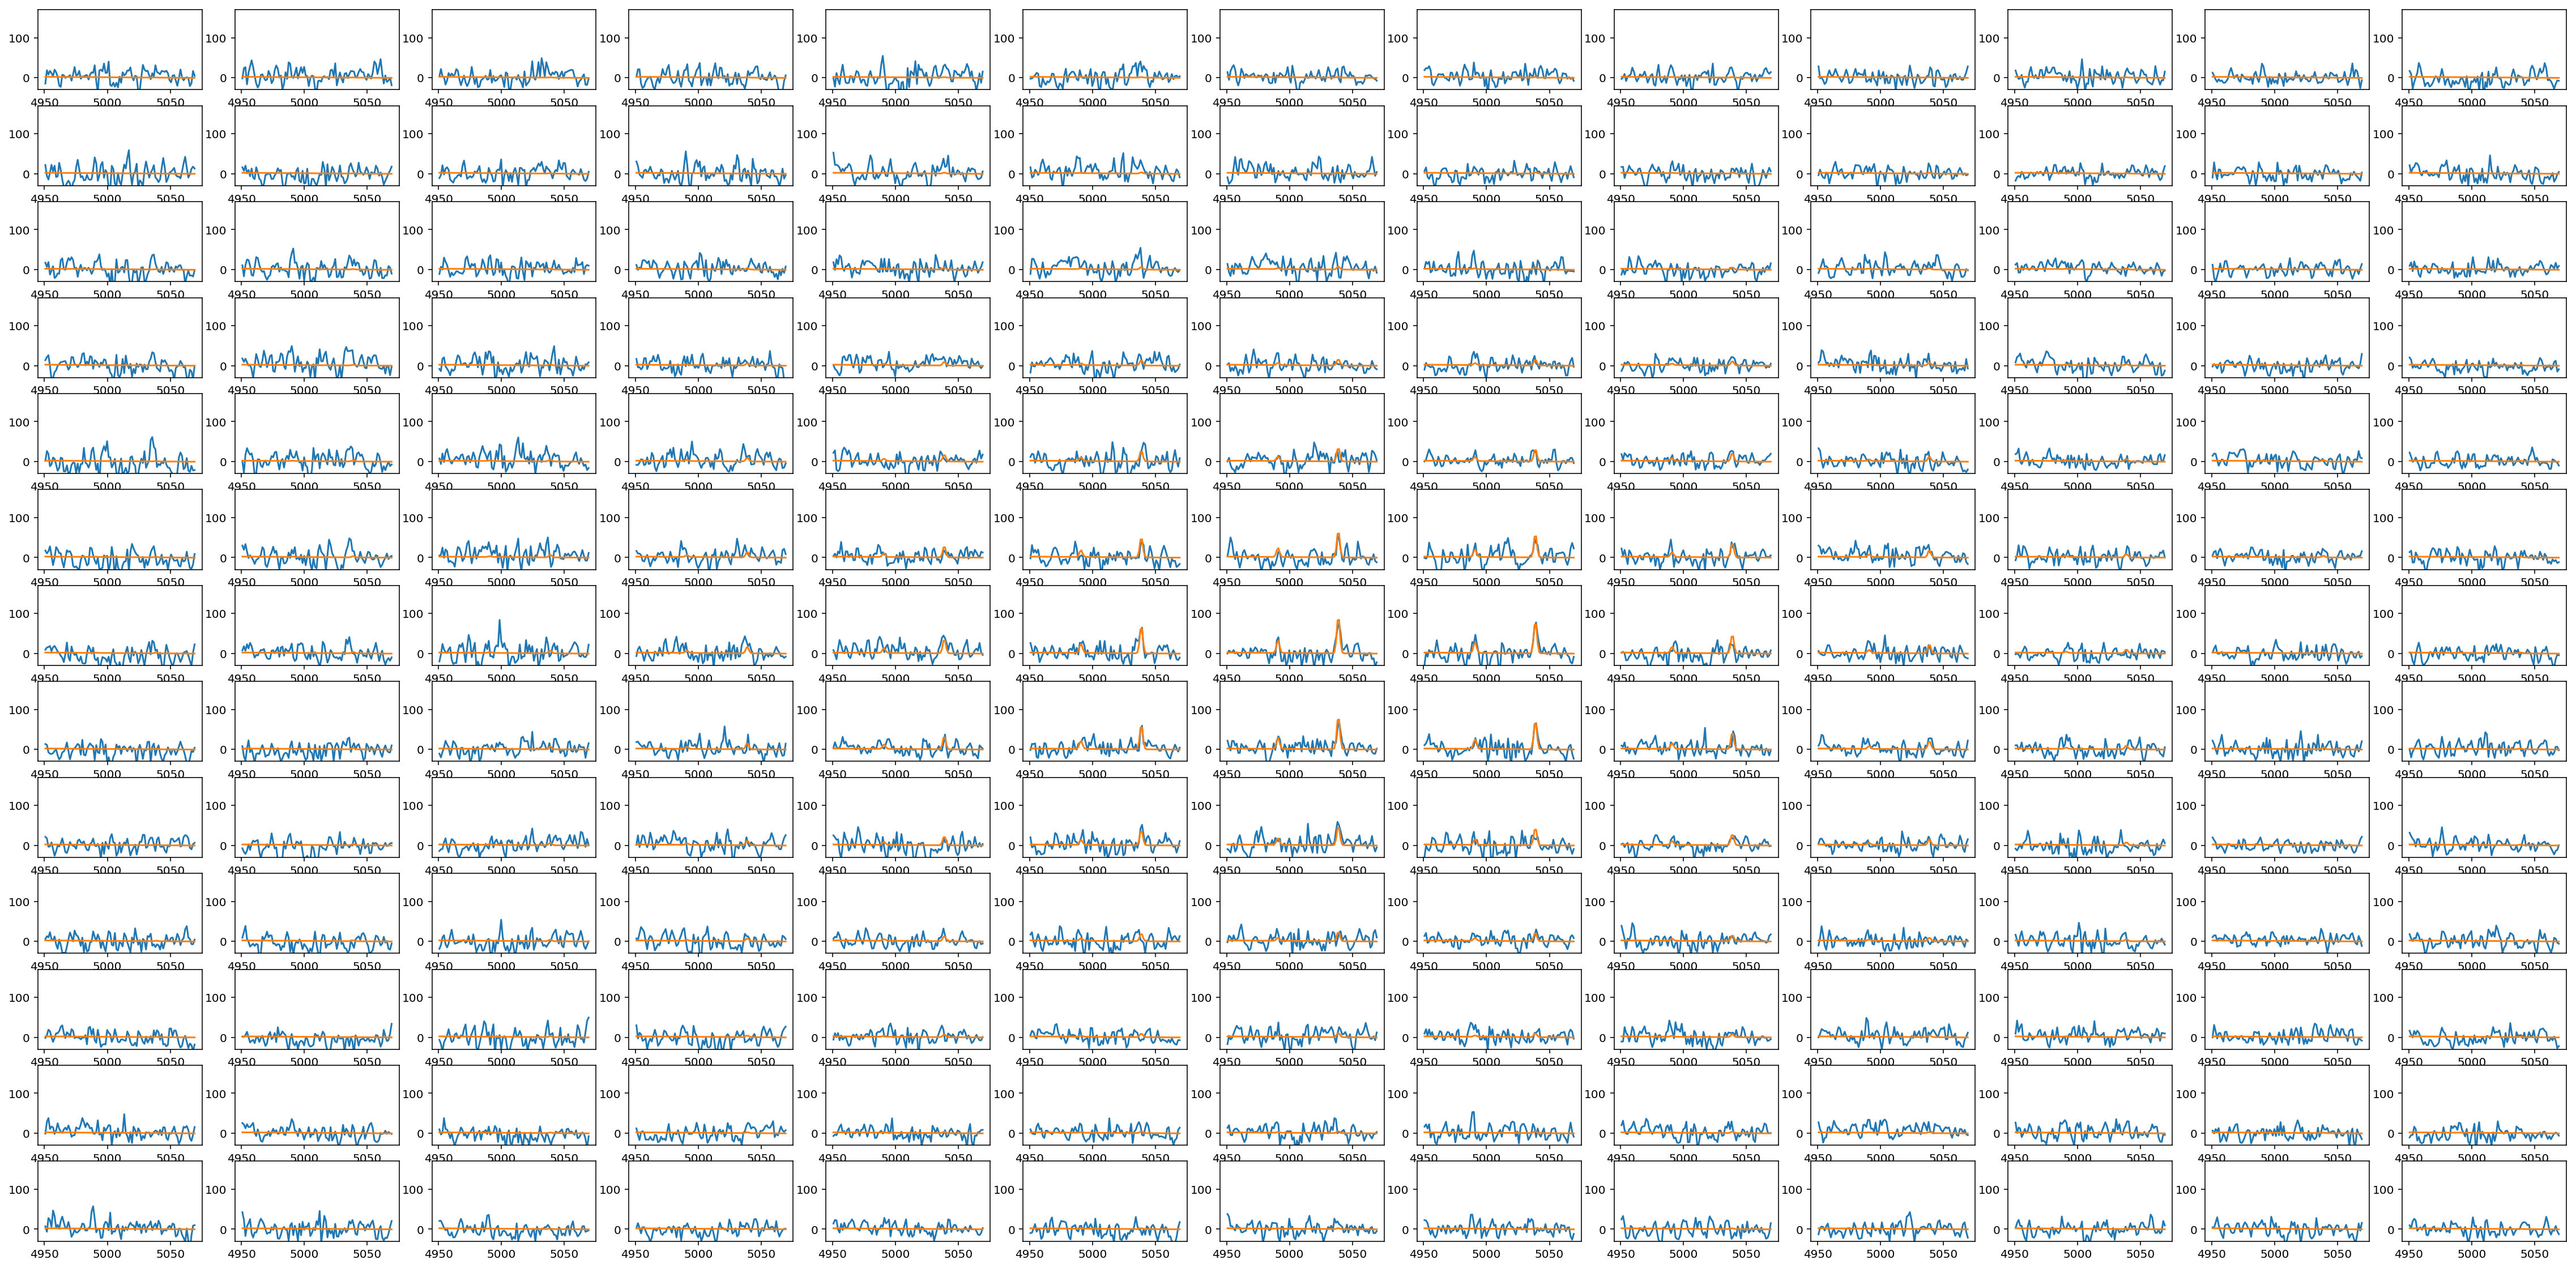

In [15]:
p = 35
PNe_n = PNe_spectra[p]
flux_1D = F_OIII_xy_list[p]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                 (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]

plt.figure(figsize=(40,20))
for i, spec in enumerate(PNe_n):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(wavelength, spec)
    plt.plot(wavelength, list_of_gauss[i])
    plt.ylim(-30, 170)
    

#plt.savefig("Plots/FCC167/PNe_24 spectra grid.png")

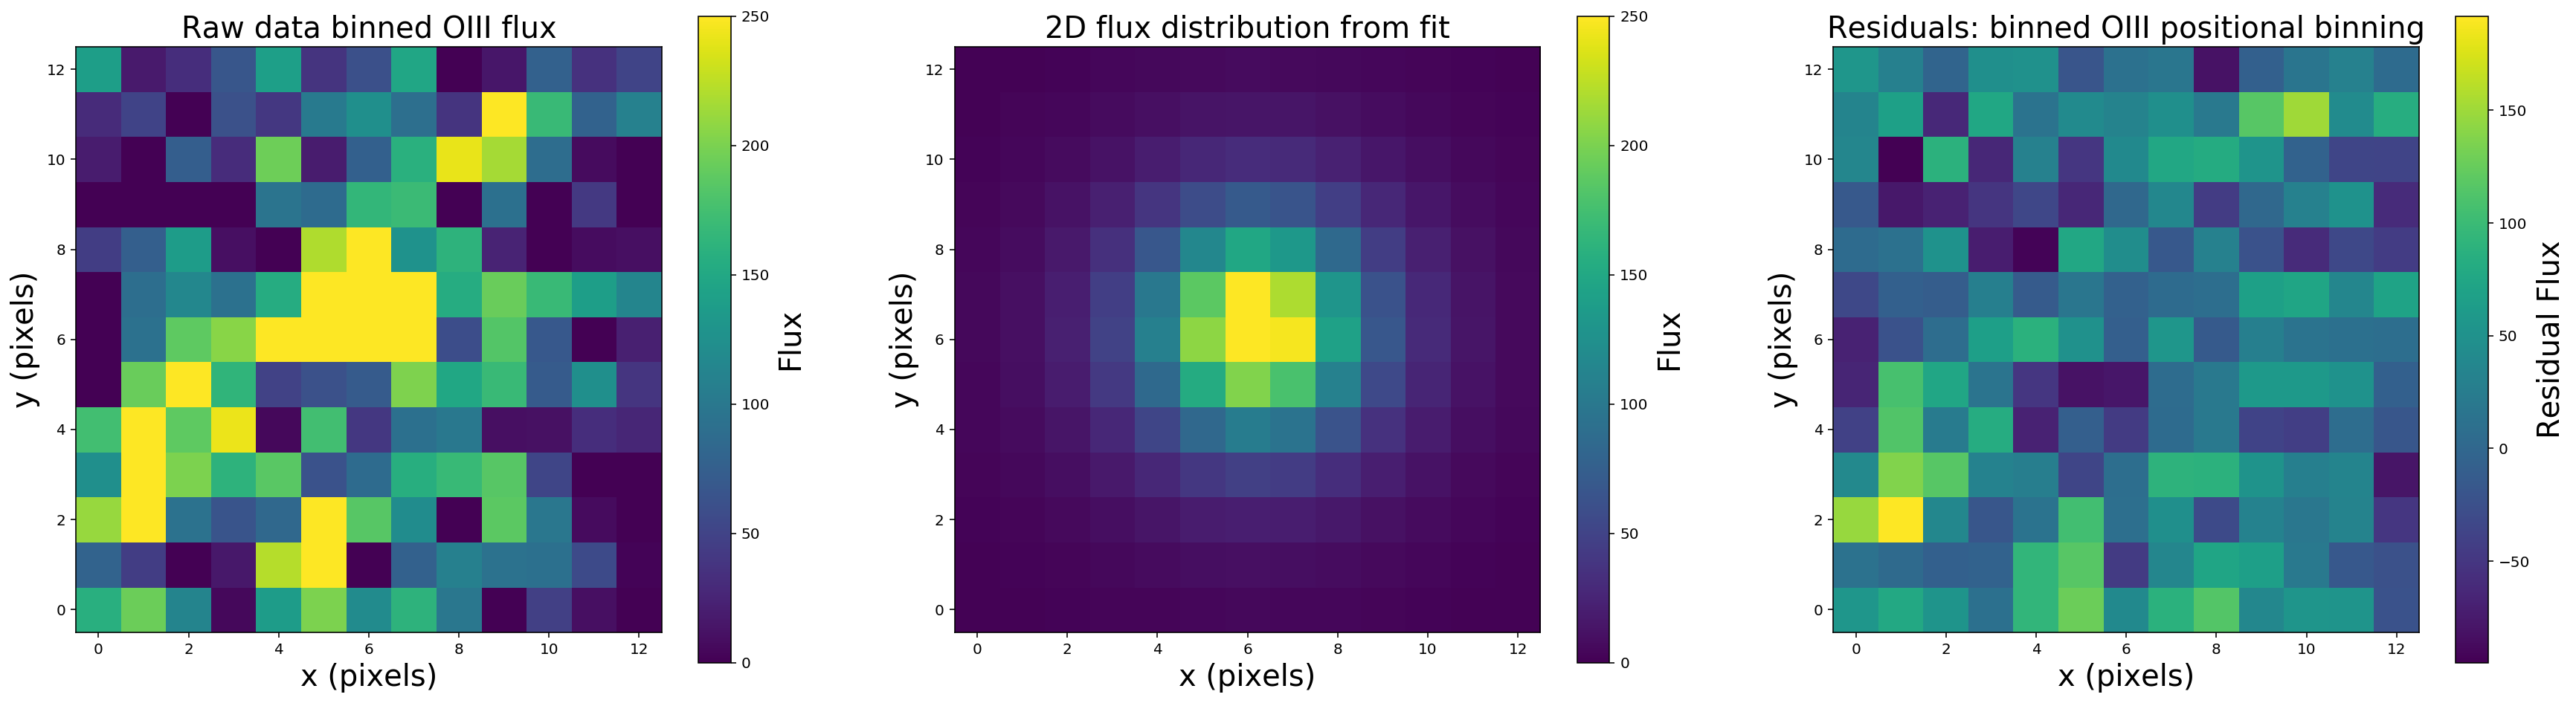

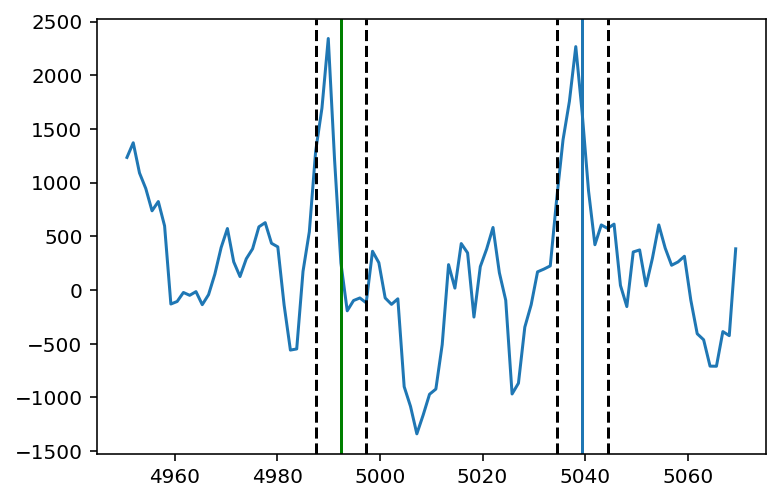

In [13]:
#(p, p+1)
for n in np.arange(p,p+1):#0, len(x_PNe)):
    PNe_n = PNe_spectra[n]
    sum_n = np.sum(PNe_n,0)
    mean_n = mean_wave_list[n]
    peak_0 = min(range(len(wavelength)), key=lambda i: abs(wavelength[i]-mean_wave_list[n]))
    peak_1 = min(range(len(wavelength)), key=lambda i: abs(wavelength[i]-(mean_wave_list[n]-47.93)))
    if (peak_1 is not peak_0 - 38) or (peak_1 is not peak_0 - 37):
        peak_1 = peak_0 - 38
    
    sum_peak_0 = np.sum(PNe_n[:,peak_0-4:peak_0+4],1)
    sum_peak_1 = np.sum(PNe_n[:,peak_1-4:peak_1+4],1)
    combined_peaks = sum_peak_0 + sum_peak_1
    combined_peaks_2D = combined_peaks.reshape(n_pixels, n_pixels)
    
    result_res = list_of_fit_residuals[n]
    result_res_list = result_res.reshape(n_pixels* n_pixels, len(wavelength))
    sum_peak_res_0 = np.sum(result_res_list[:,peak_0-2:peak_0+2],1)
    sum_peak_res_1 = np.sum(result_res_list[:,peak_1-2:peak_1+2],1)
    combined_peaks_res = sum_peak_res_0 + sum_peak_res_1
    combined_peaks_res_2D = combined_peaks_res.reshape(n_pixels, n_pixels)
    
    plt.figure(figsize=(30,8))
    plt.subplot(1,3,1)
    plt.imshow(combined_peaks_2D, origin="lower", vmin=0, vmax=250)
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("Raw data binned OIII flux", fontsize=20)
    #ax = plt.gca()
    #circ = plt.Circle((list_of_y[n],list_of_x[n]),3, color="white", fill=False)
    #ax.add_artist(circ)
    cb = plt.colorbar(label="Flux")
    cb.set_label("Flux", fontsize=20)
    
    plt.subplot(1,3,2)
    plt.imshow(F_OIII_xy_list[n].reshape(n_pixels,n_pixels), origin="lower", vmin=0, vmax=250)
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("2D flux distribution from fit", fontsize=20)
    #ax = plt.gca()
    #circ = plt.Circle((list_of_y[n],list_of_x[n]),3, color="white", fill=False)
    #ax.add_artist(circ)
    cb = plt.colorbar()
    cb.set_label("Flux", fontsize=20)
    
    plt.subplot(1,3,3)
    plt.imshow(combined_peaks_res_2D, origin="lower", vmin=np.min(combined_peaks_res_2D), vmax=np.max(combined_peaks_res_2D))
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("Residuals: binned OIII positional binning", fontsize=20)
    cb = plt.colorbar()
    cb.set_label("Residual Flux", fontsize=20)
    
    #plt.savefig("Plots/FCC167/data_model_residual_.png")
    
    plt.figure(7)
    plt.plot(wavelength, sum_n)
    plt.axvline(wavelength[peak_0])
    plt.axvline(wavelength[peak_0+4], ls="dashed", c="k")
    plt.axvline(wavelength[peak_0-4], ls="dashed", c="k")
    
    plt.axvline(wavelength[peak_1], c="green")
    plt.axvline(wavelength[peak_1+4], ls="dashed", c="k")
    plt.axvline(wavelength[peak_1-4], ls="dashed", c="k")


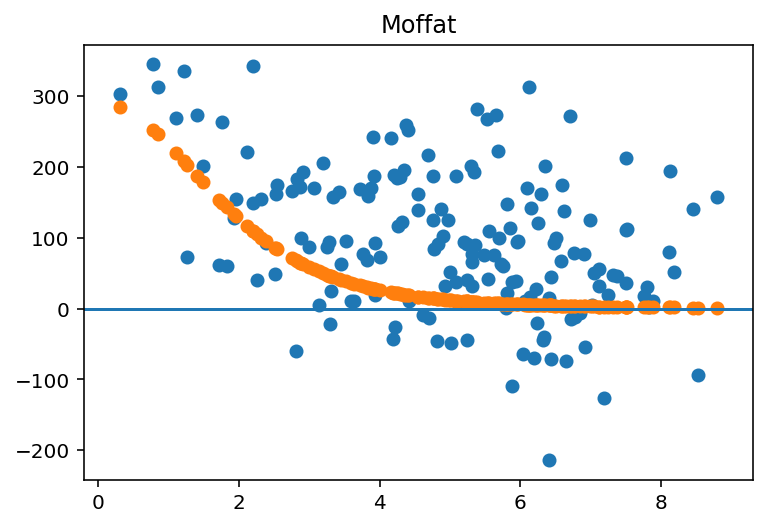

In [14]:
PNe_radials= np.sqrt((x_fit - list_of_x[p])**2 + (y_fit - list_of_y[p])**2)
plt.title("Moffat")
plt.scatter(PNe_radials, combined_peaks_2D)
plt.scatter(PNe_radials, F_OIII_xy_list[p])
#plt.axvline(r)
plt.axhline(0)

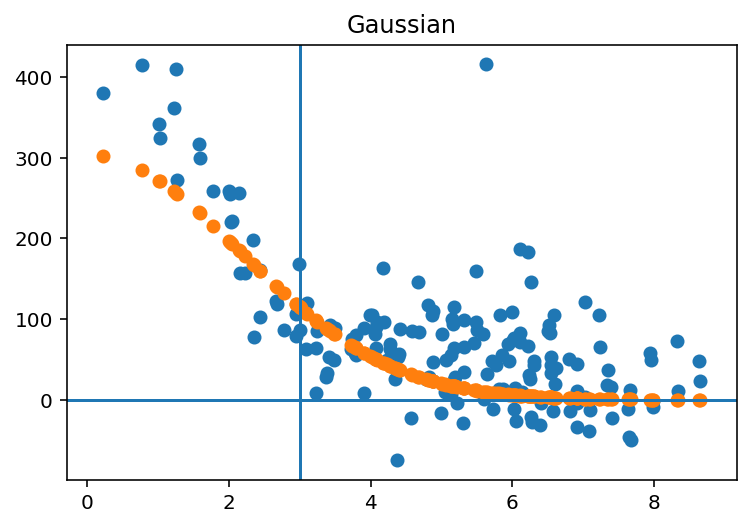

In [30]:
PNe_radials= np.sqrt((x_fit - list_of_x[p])**2 + (y_fit - list_of_y[p])**2)
plt.title("Gaussian")
plt.scatter(PNe_radials, combined_peaks_2D)
plt.scatter(PNe_radials, F_OIII_xy_list[p])
plt.axvline(r)
plt.axhline(0)

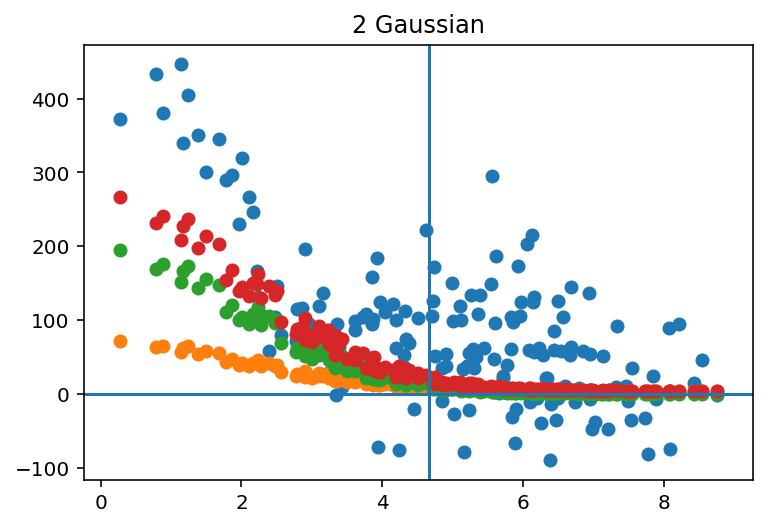

In [10]:
PNe_radials= np.sqrt((x_fit - list_of_x[p])**2 + (y_fit - list_of_y[p])**2)
plt.title("2 Gaussian")
plt.scatter(PNe_radials, combined_peaks_2D)
plt.scatter(PNe_radials, useful_stuff[1][2])
plt.scatter(PNe_radials, useful_stuff[1][3])
plt.scatter(PNe_radials, useful_stuff[1][3]+useful_stuff[1][2])
plt.axvline((11/2.3548))
plt.axhline(0)

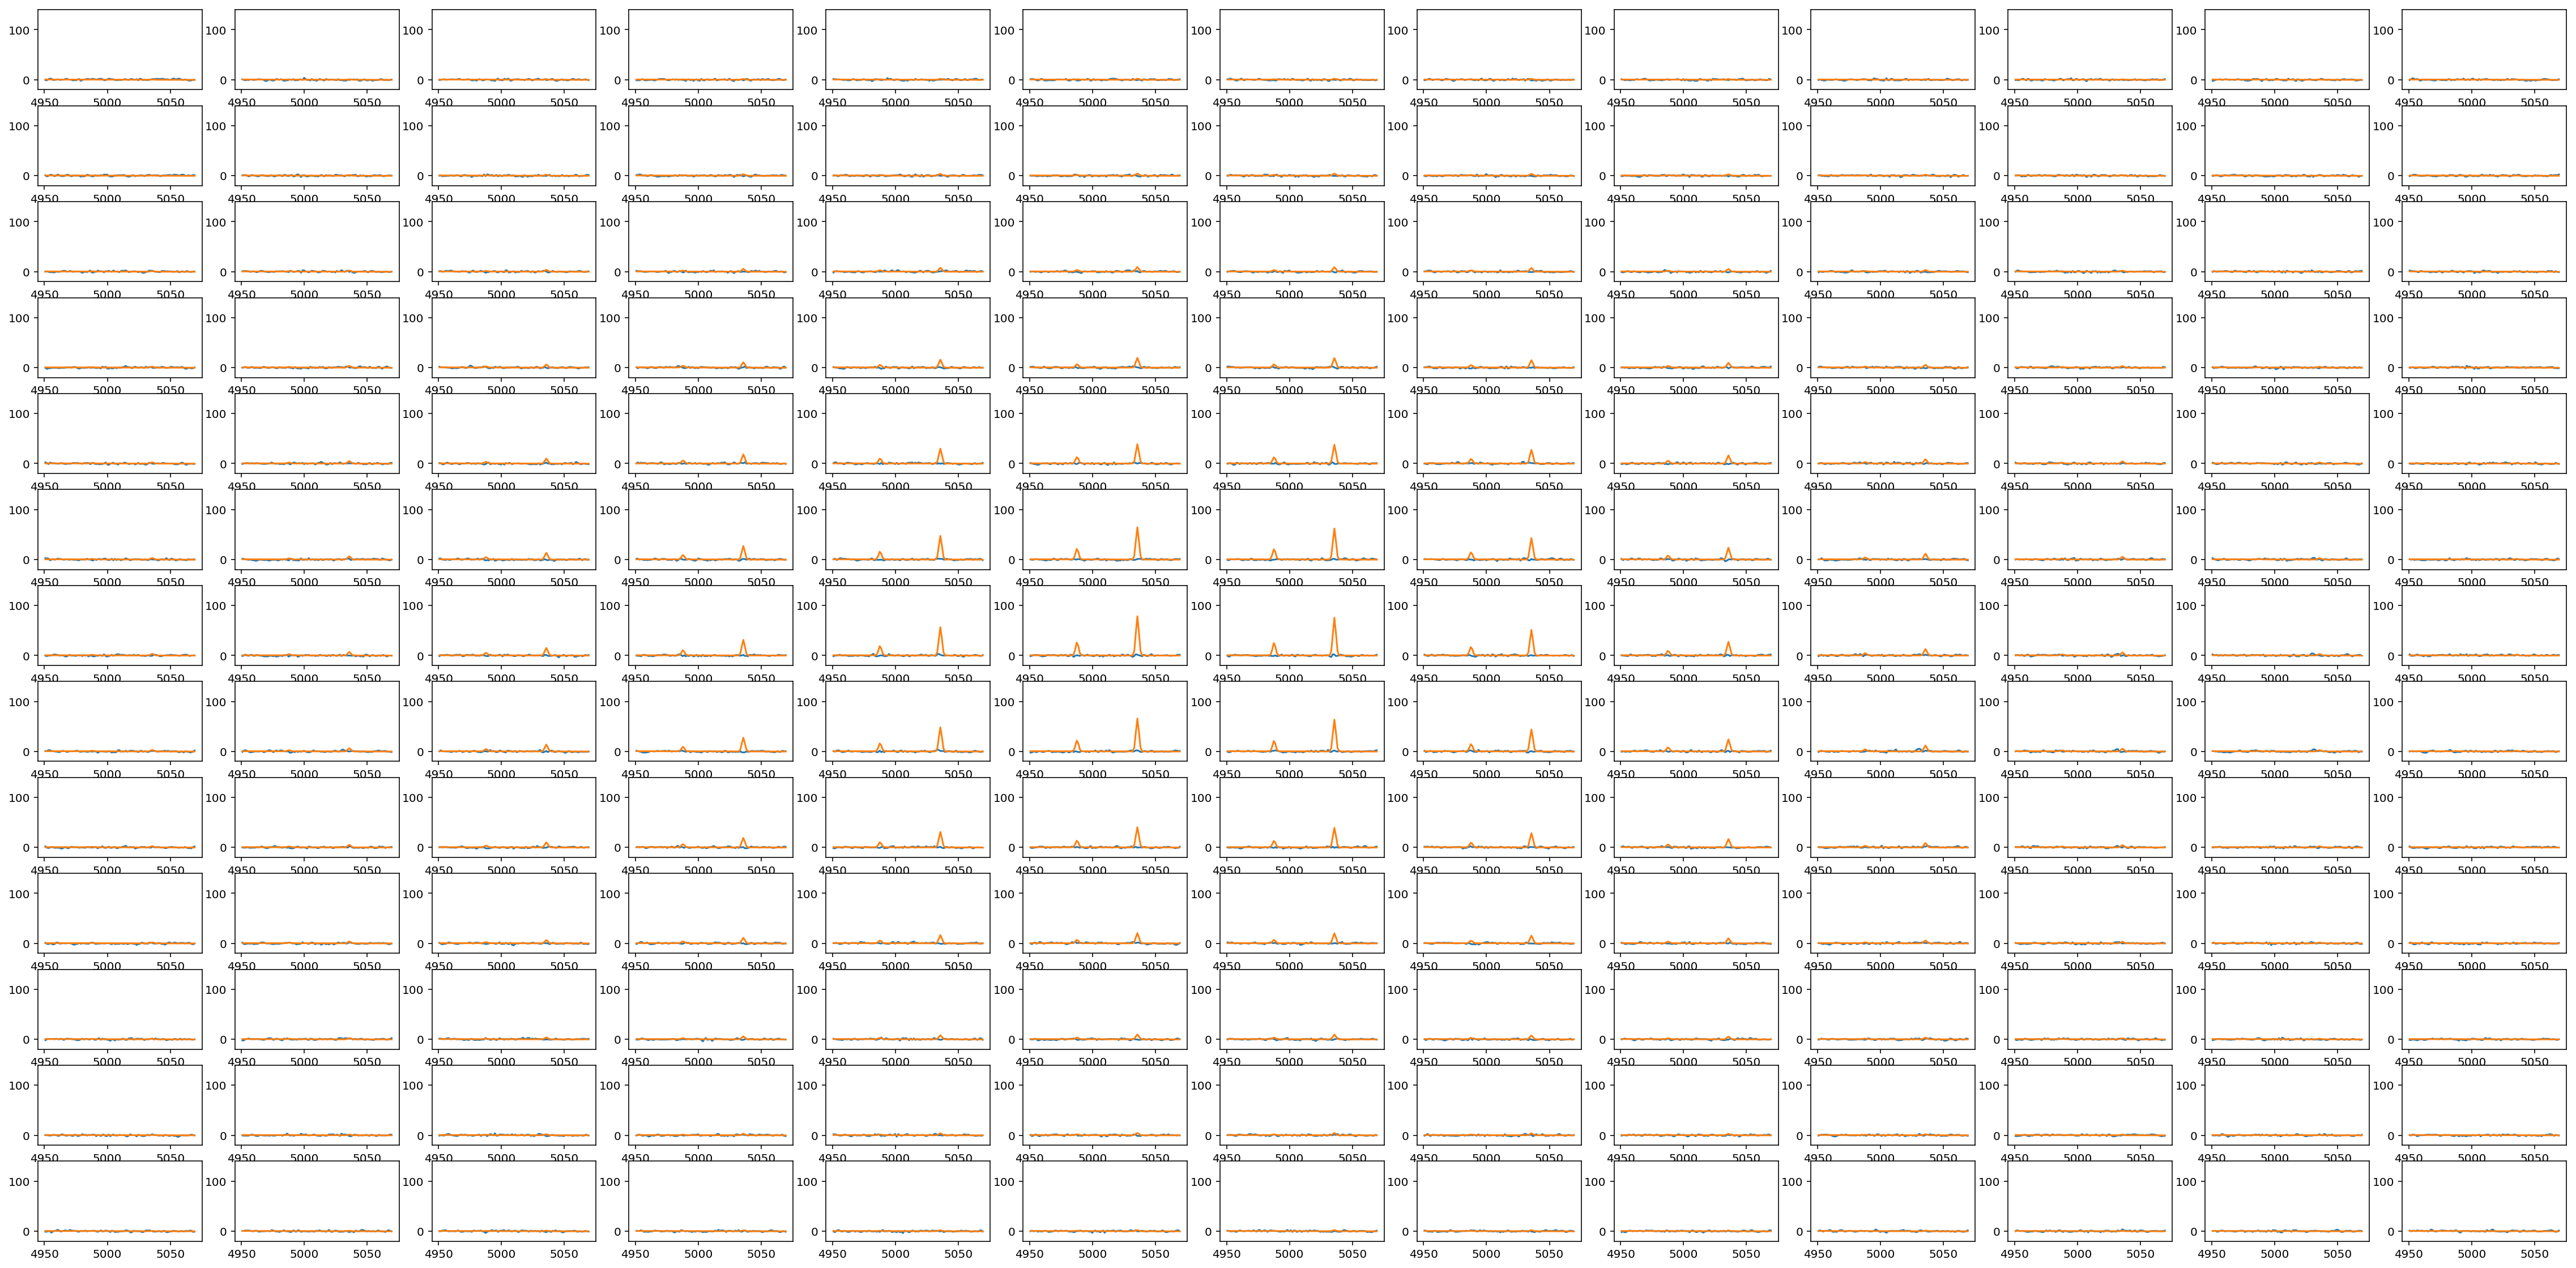

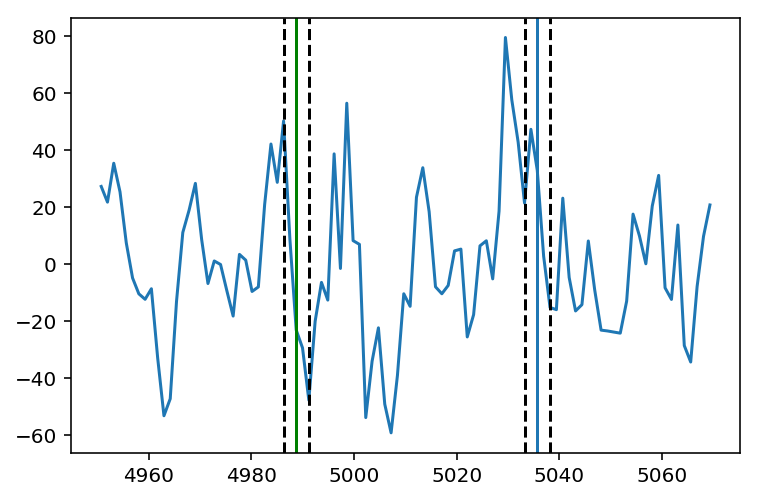

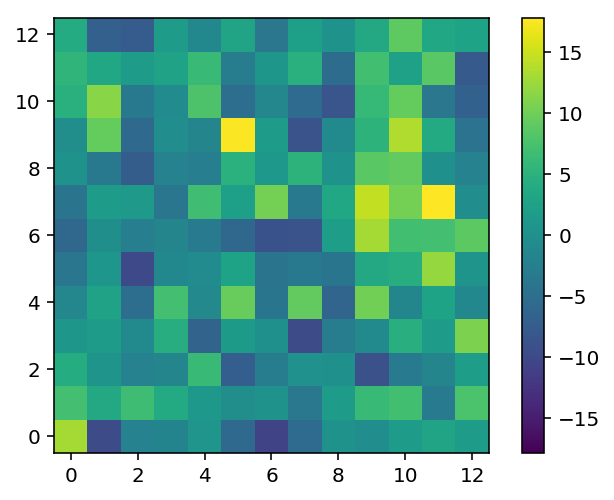

In [16]:
# Residual
result_res = fit_results.residual
result_res_list = result_res.reshape(n_pixels* n_pixels, len(wavelength))
plt.figure(0,figsize=(40,20))
for i, spec in enumerate(result_res_list):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(wavelength, spec)
    plt.plot(wavelength, list_of_gauss[i])
    plt.ylim(-20,140)

sum_n_res = np.sum(result_res_list,0)
plt.figure(1)
plt.plot(wavelength, sum_n_res)
plt.axvline(wavelength[peak_0])
plt.axvline(wavelength[peak_0+2], ls="dashed", c="k")
plt.axvline(wavelength[peak_0-2], ls="dashed", c="k")

plt.axvline(wavelength[peak_1], c="green")
plt.axvline(wavelength[peak_1+2], ls="dashed", c="k")
plt.axvline(wavelength[peak_1-2], ls="dashed", c="k")

mean_n = mean_wave_list[n]
sum_peak_0 = np.sum(result_res_list[:,peak_0-4:peak_0+4],1)
sum_peak_1 = np.sum(result_res_list[:,peak_1-4:peak_1+4],1)
combined_peaks = sum_peak_0 + sum_peak_1
plt.figure(2)
plt.imshow(combined_peaks.reshape(n_pixels, n_pixels), origin="lower", vmin=-np.max(combined_peaks), vmax=np.max(combined_peaks))
plt.colorbar()

# Completeness

In [21]:
Noise_map = np.abs(np.std(raw_data_cube, axis=2))

# mask out regions where sep masks
Y, X = np.mgrid[:y_data, :x_data]
xe = 236
ye = 197
length= 140
wide = 60
alpha = 0.2
elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (wide/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1

Noise_map[elip_mask_gal == True] = 0.0

#plt.imshow(Noise_map, origin="lower", cmap="CMRmap", vmin=0, vmax=20)

# Setup range of Absolute Magnitudes to be converted to 1D max A values
#Abs_M = bins_cens # np.arange(-4.5,-1.5, 0.5)#bins_cens
#dM = 5. * np.log10(18.7)+25
app_m = bins_cens

total_flux = 10**((app_m + 13.74) / -2.5)
flux = total_flux / 1e-20

def moffat(amplitude, x_0, y_0, FWHM, beta):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2 + (y_fit - y_0)**2) / gamma**2
    return amplitude * (1 + rr_gg)**(-beta)

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                 (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

init_FWHM = PNe_params["M_FWHM"].value
init_beta = PNe_params["beta"].value
sum_init = np.sum(moffat(1, n_pixels/2, n_pixels/2, init_FWHM, init_beta))
input_moff_A = flux / sum_init

# Make moffat models = F_5007 (x,y)
Moffat_models = np.array([moffat(moff_A, n_pixels/2., n_pixels/2., init_FWHM, init_beta) for moff_A in input_moff_A])

# A_5007 (x,y)
Amp_x_y = ((Moffat_models) / (np.sqrt(2*np.pi) * 1.19))

max_1D_A = np.array([np.max(A) for A in Amp_x_y])

N_data = len(np.nonzero(Noise_map)[0])

Noise_mask = Noise_map
Noise_mask_plot = []
ratio_counter = np.zeros(len(app_m))
for i,a in enumerate(max_1D_A):
    Noise_mask[((a / Noise_map) <2.0)] = np.nan
    nan_counter = np.isnan(Noise_mask).sum()

    ratio_counter[i] = (N_data-nan_counter) / N_data
    Noise_mask_plot.append(Noise_mask)
#    plt.figure(figsize=(14,14))
#    plt.title("Absolute Magniude %s" %Abs_M[i])
#    plt.imshow(Noise_mask, origin="lower", vmin=0, vmax=20)
#    cb=plt.colorbar()
#    plt.savefig("Plots/FCC167/completeness/Abs M %s.png" %Abs_M[i])
#
#Noise_mask = Noise_map
#Noise_mask_plot = []
#
#fig, axs = plt.subplots(2,3, figsize=(20, 10))
#axs = axs.ravel()
#for i,a in enumerate(max_1D_A):
#    Noise_mask[((a / Noise_map) <2.0)] = np.nan
#    axs[i].set_title("$M_{5007} = $ %s" %Abs_M[i])
#    ax = axs[i].imshow(Noise_mask, origin="lower", vmin=0, vmax=30)
#
#plt.savefig("Plots/FCC167/completeness/stack.png")



/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


## PNLF Fitting Routine

In [22]:
PNLF_df = pd.DataFrame(columns=("m 5007", "PNLF", "binned_values"))
PNLF_df["m 5007"] = PNe_df["m 5007"].loc[PNe_df["A/rN"]>2.0]

diff = abs(bins_cens[0]-bins_cens[1]) / 2
bins_cens_left = bins_cens - diff
bins_cens_right = bins_cens + diff

PNLF_df["binned_values"] = np.digitize(PNLF_df["m 5007"], bins=bins_cens)

def PNLF_func(params, data):
    c1 = params["c1"]
    c2 = params["c2"]
    
    # PNLF equation
    PNLF = c1*np.exp(c2*PNLF_df["m 5007"]) * (1-np.exp(3*((PNLF_df["m 5007"].min() - PNLF_df["m 5007"]))))
    PNLF_df["PNLF"] = PNLF
    # Binning of PNLF values
    PNLF_sum_list = np.zeros(len(bins_cens))
    for i in np.arange(1,len(bins_cens)+1):
        PNLF_sum_list[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    # Scale the binned values

    return data - PNLF_sum_list
                
params_PNLF = Parameters()
params_PNLF.add("c1", value=50)
params_PNLF.add("c2", value=0.5)

results = minimize(PNLF_func, params_PNLF, args=(bins,), nan_policy="propagate")
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2], edgecolor="black", linewidth=0.8, label="M 5007 >2 * A/rN", alpha=0.5)
report_fit(results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 814
    # data points      = 14
    # variables        = 2
    chi-square         = 109.695400
    reduced chi-square = 9.14128332
    Akaike info crit   = 32.8211014
    Bayesian info crit = 34.0992161
[[Variables]]
    c1:  6.1092e+16 +/- 7.5875e+17 (1241.98%) (init = 50)
    c2: -1.32963816 +/- 0.45221607 (34.01%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2) = -1.000


[1.38625384 5.35751079 7.11987257 7.76004195 7.69365299 7.33535967
 6.64868244 6.07385185 5.37550531 4.8444074  4.34111777 3.78513673
 3.32478789 2.84281003]


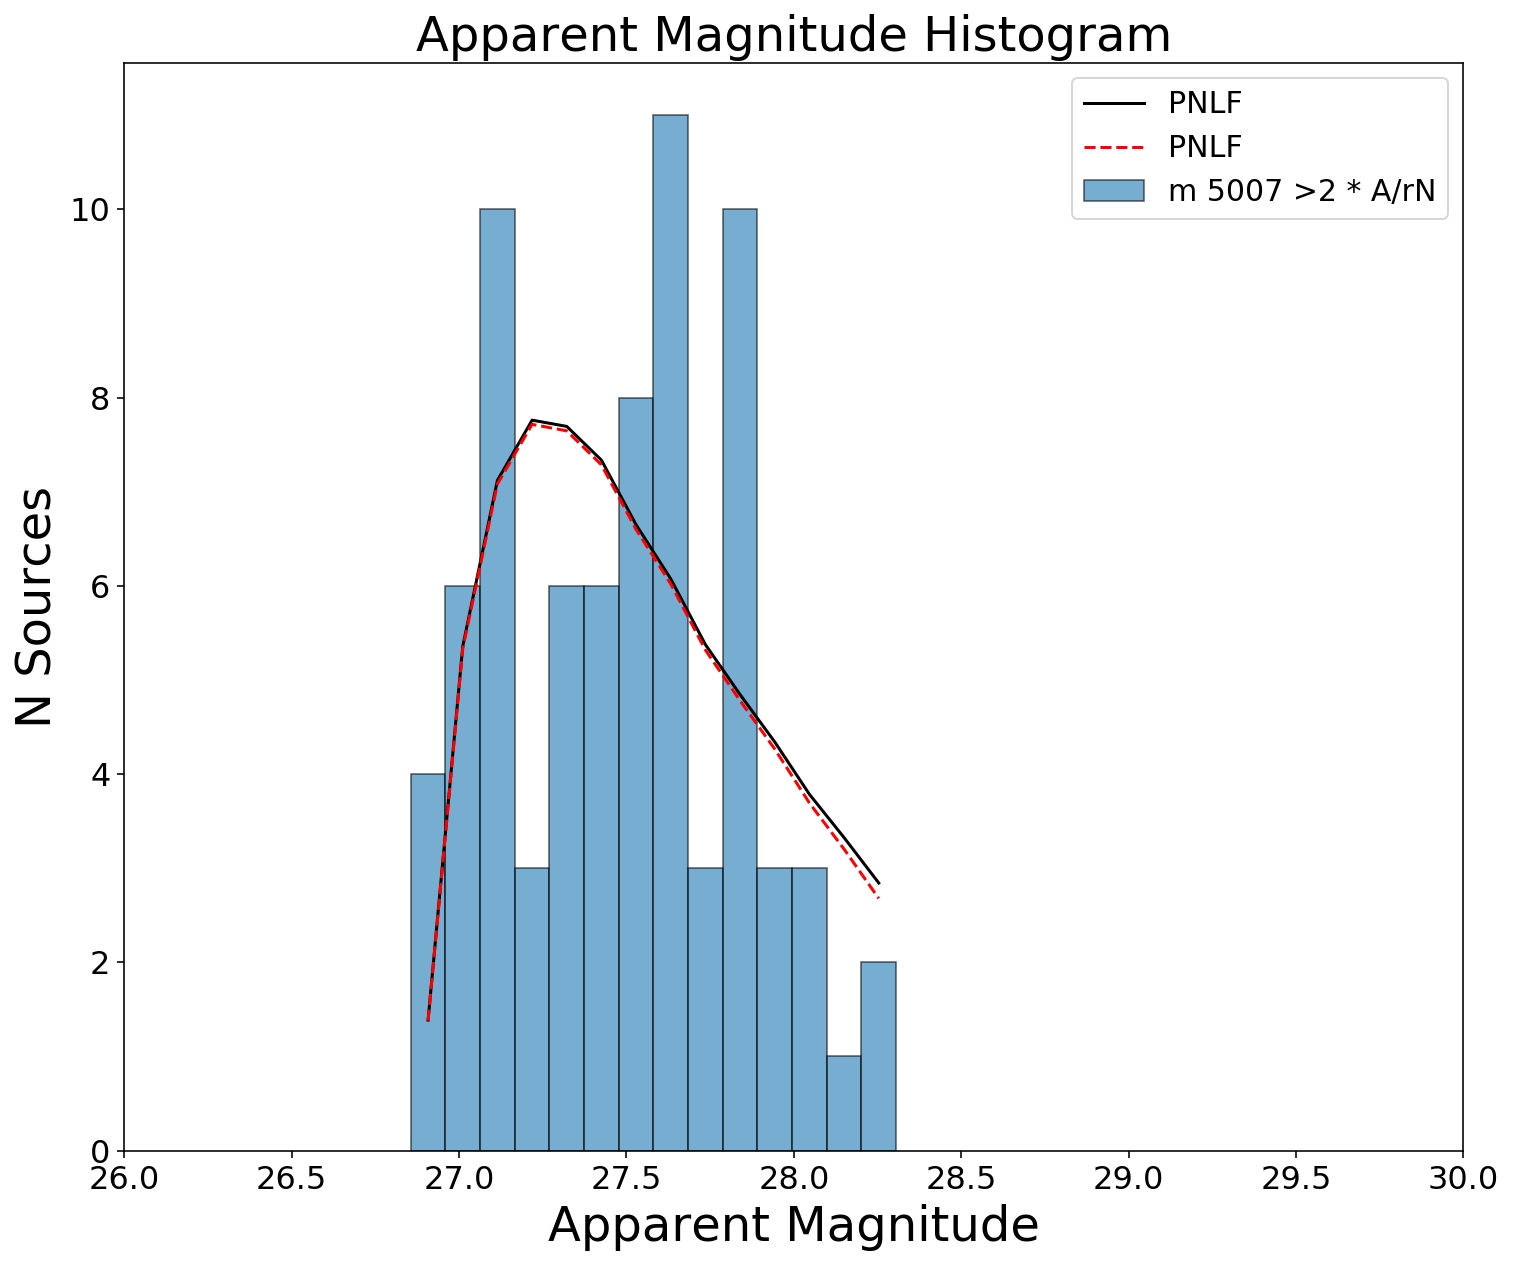

In [24]:
plt.figure(2, figsize=(12,10))
info = plt.hist(PNe_df["m 5007"].loc[PNe_df["A/rN"]>2], bins=len(bins), edgecolor="black", linewidth=0.8, label="m 5007 >2 * A/rN", alpha=0.6)
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]<2], bins=4, edgecolor="black",linewidth=0.8, color="red", alpha=0.5, label="M 5007 <2 * A/rN")
ax = plt.gca()
plt.xlim(26.,30.0)
#plt.yticks(np.arange(0,22,2), np.arange(0,22,2))
plt.title("Apparent Magnitude Histogram", fontsize=24)
plt.xlabel("Apparent Magnitude", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
ax.get_yticklabels()
ax.tick_params(labelsize=18)
ax.tick_params(labelsize=16)
#plt.savefig("Plots/FCC167/M5007 histogram.png")

PNLF = results.params["c1"].value*(np.exp(np.abs(results.params["c2"].value)*PNe_df["m 5007"])) * (1-np.exp(3*((PNe_df["m 5007"].min() - PNe_df["m 5007"]))))
#PNLF = (PNLF * results.params["a"]) 
#plt.scatter(PNe_df["M 5007"].loc[PNe_df["M 5007"]>-5], PNLF, c="k")


binned_PNLF = np.zeros(len(bins_cens))
for i in np.arange(1,len(bins_cens)+1):
    binned_PNLF[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    
print(binned_PNLF)
plt.plot(bins_cens_right, (binned_PNLF), color="k", label="PNLF" )
plt.plot(bins_cens_right, (binned_PNLF) * ratio_counter, color="r", ls="--", label="PNLF" )
plt.legend(fontsize=15)
plt.savefig("Plots/FCC167/PNLF.png")

## Error estimation

In [19]:
def MUSE_3D_err(params, l, x_2D, y_2D, data):
    moffat_amp = params['A_err']
    x_0 = params['x_err']
    y_0 = params['y_err']
    FWHM = params['FWHM_err']
    beta = params["beta_err"]
    mean = params["mean_err"]
    Gauss_FWHM = params["Gauss_FWHM_err"]
    Gauss_bkg = params["Gauss_bkg_err"]
    Gauss_grad = params["Gauss_grad_err"]
    
    #Moffat model
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    F_OIII_xy = moffat_amp * (1 + rr_gg)**(-beta)
    
    comb_FWHM = np.sqrt(2.81**2 + Gauss_FWHM**2)
    Gauss_std = comb_FWHM / 2.35482
    
    # Convert Moffat flux to amplitude
    A_OIII_xy = ((F_OIII_xy) / (np.sqrt(2*np.pi) * Gauss_std))
    
    #Construct model gaussian profiles for each amplitude value in cube
    model_spectra = [(Gauss_bkg + (Gauss_grad * l) + np.abs(Amp) * np.exp(- 0.5 * (l - mean)** 2 / Gauss_std**2.) +
             (np.abs(Amp)/3.0) * np.exp(- 0.5 * (l - (mean - 47.9399))** 2 / Gauss_std**2.)) for Amp in A_OIII_xy]
    
    return np.sum(F_OIII_xy * 1e-20)

high_F_list = np.zeros(len(x_PNe))
low_F_list = np.zeros(len(x_PNe))

for num in np.arange(0, len(x_PNe)):
    error_params_add = Parameters()
    error_params_add.add("A_err", value=M_amp_list[num] + moff_A_err[num], vary=False)
    error_params_add.add("x_err", value=list_of_x[num] + x_0_err[num], vary=False)
    error_params_add.add("y_err", value=list_of_y[num] + y_0_err[num], vary=False)
    error_params_add.add("FWHM_err", value=PNe_params["FWHM"].value + FWHM_in_err, vary=False)
    error_params_add.add("beta_err", value=PNe_params["beta"].value + beta_in_err, vary=False)
    error_params_add.add("mean_err", value=mean_wave_list[num] + mean_wave_err[num], vary=False)
    error_params_add.add("Gauss_FWHM_err", value=PNe_params["Gauss_FWHM"].value + 0.0, vary=False)
    error_params_add.add("Gauss_bkg_err", value=Gauss_bkg[num] + Gauss_bkg_err[num], vary=False)
    error_params_add.add("Gauss_grad_err", value=Gauss_grad[num] + Gauss_grad_err[num], vary=False)
    
    error_params_minus = Parameters()
    error_params_minus.add("A_err", value=M_amp_list[num] - moff_A_err[num], vary=False)
    error_params_minus.add("x_err", value=list_of_x[num] - x_0_err[num], vary=False)
    error_params_minus.add("y_err", value=list_of_y[num] - y_0_err[num], vary=False)
    error_params_minus.add("FWHM_err", value=PNe_params["FWHM"].value - FWHM_in_err, vary=False)
    error_params_minus.add("beta_err", value=PNe_params["beta"].value - beta_in_err, vary=False)
    error_params_minus.add("mean_err", value=mean_wave_list[num] - mean_wave_err[num], vary=False)
    error_params_minus.add("Gauss_FWHM_err", value=PNe_params["Gauss_FWHM"].value - 0.0, vary=False)
    error_params_minus.add("Gauss_bkg_err", value=Gauss_bkg[num] - Gauss_bkg_err[num], vary=False)
    error_params_minus.add("Gauss_grad_err", value=Gauss_grad[num] - Gauss_grad_err[num], vary=False)
    
    model_add = MUSE_3D_err(error_params_add, wavelength, x_fit, y_fit, PNe_spectra[num])
    high_F_list[num] = model_add
    model_minus = MUSE_3D_err(error_params_minus, wavelength, x_fit, y_fit, PNe_spectra[num])
    low_F_list[num] = model_minus

delta_F_high = high_F_list - PNe_df["Total Flux"]
delta_F_low = PNe_df["Total Flux"] - low_F_list

PNe_df["Flux error"] = np.median((delta_F_high, delta_F_low))

PNe_df["M 5007 error"] = 1.09 * (PNe_df["Flux error"] / PNe_df["Total Flux"])

# Load in saved data

In [37]:
# Pull out the 1D flux data from 1D fits to do radial comparison
gauss_1D_A = np.load("exported_data/FCC167/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/FCC167/A_rN_cen.npy")

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

## Flux and A/rN maps, with circled sources

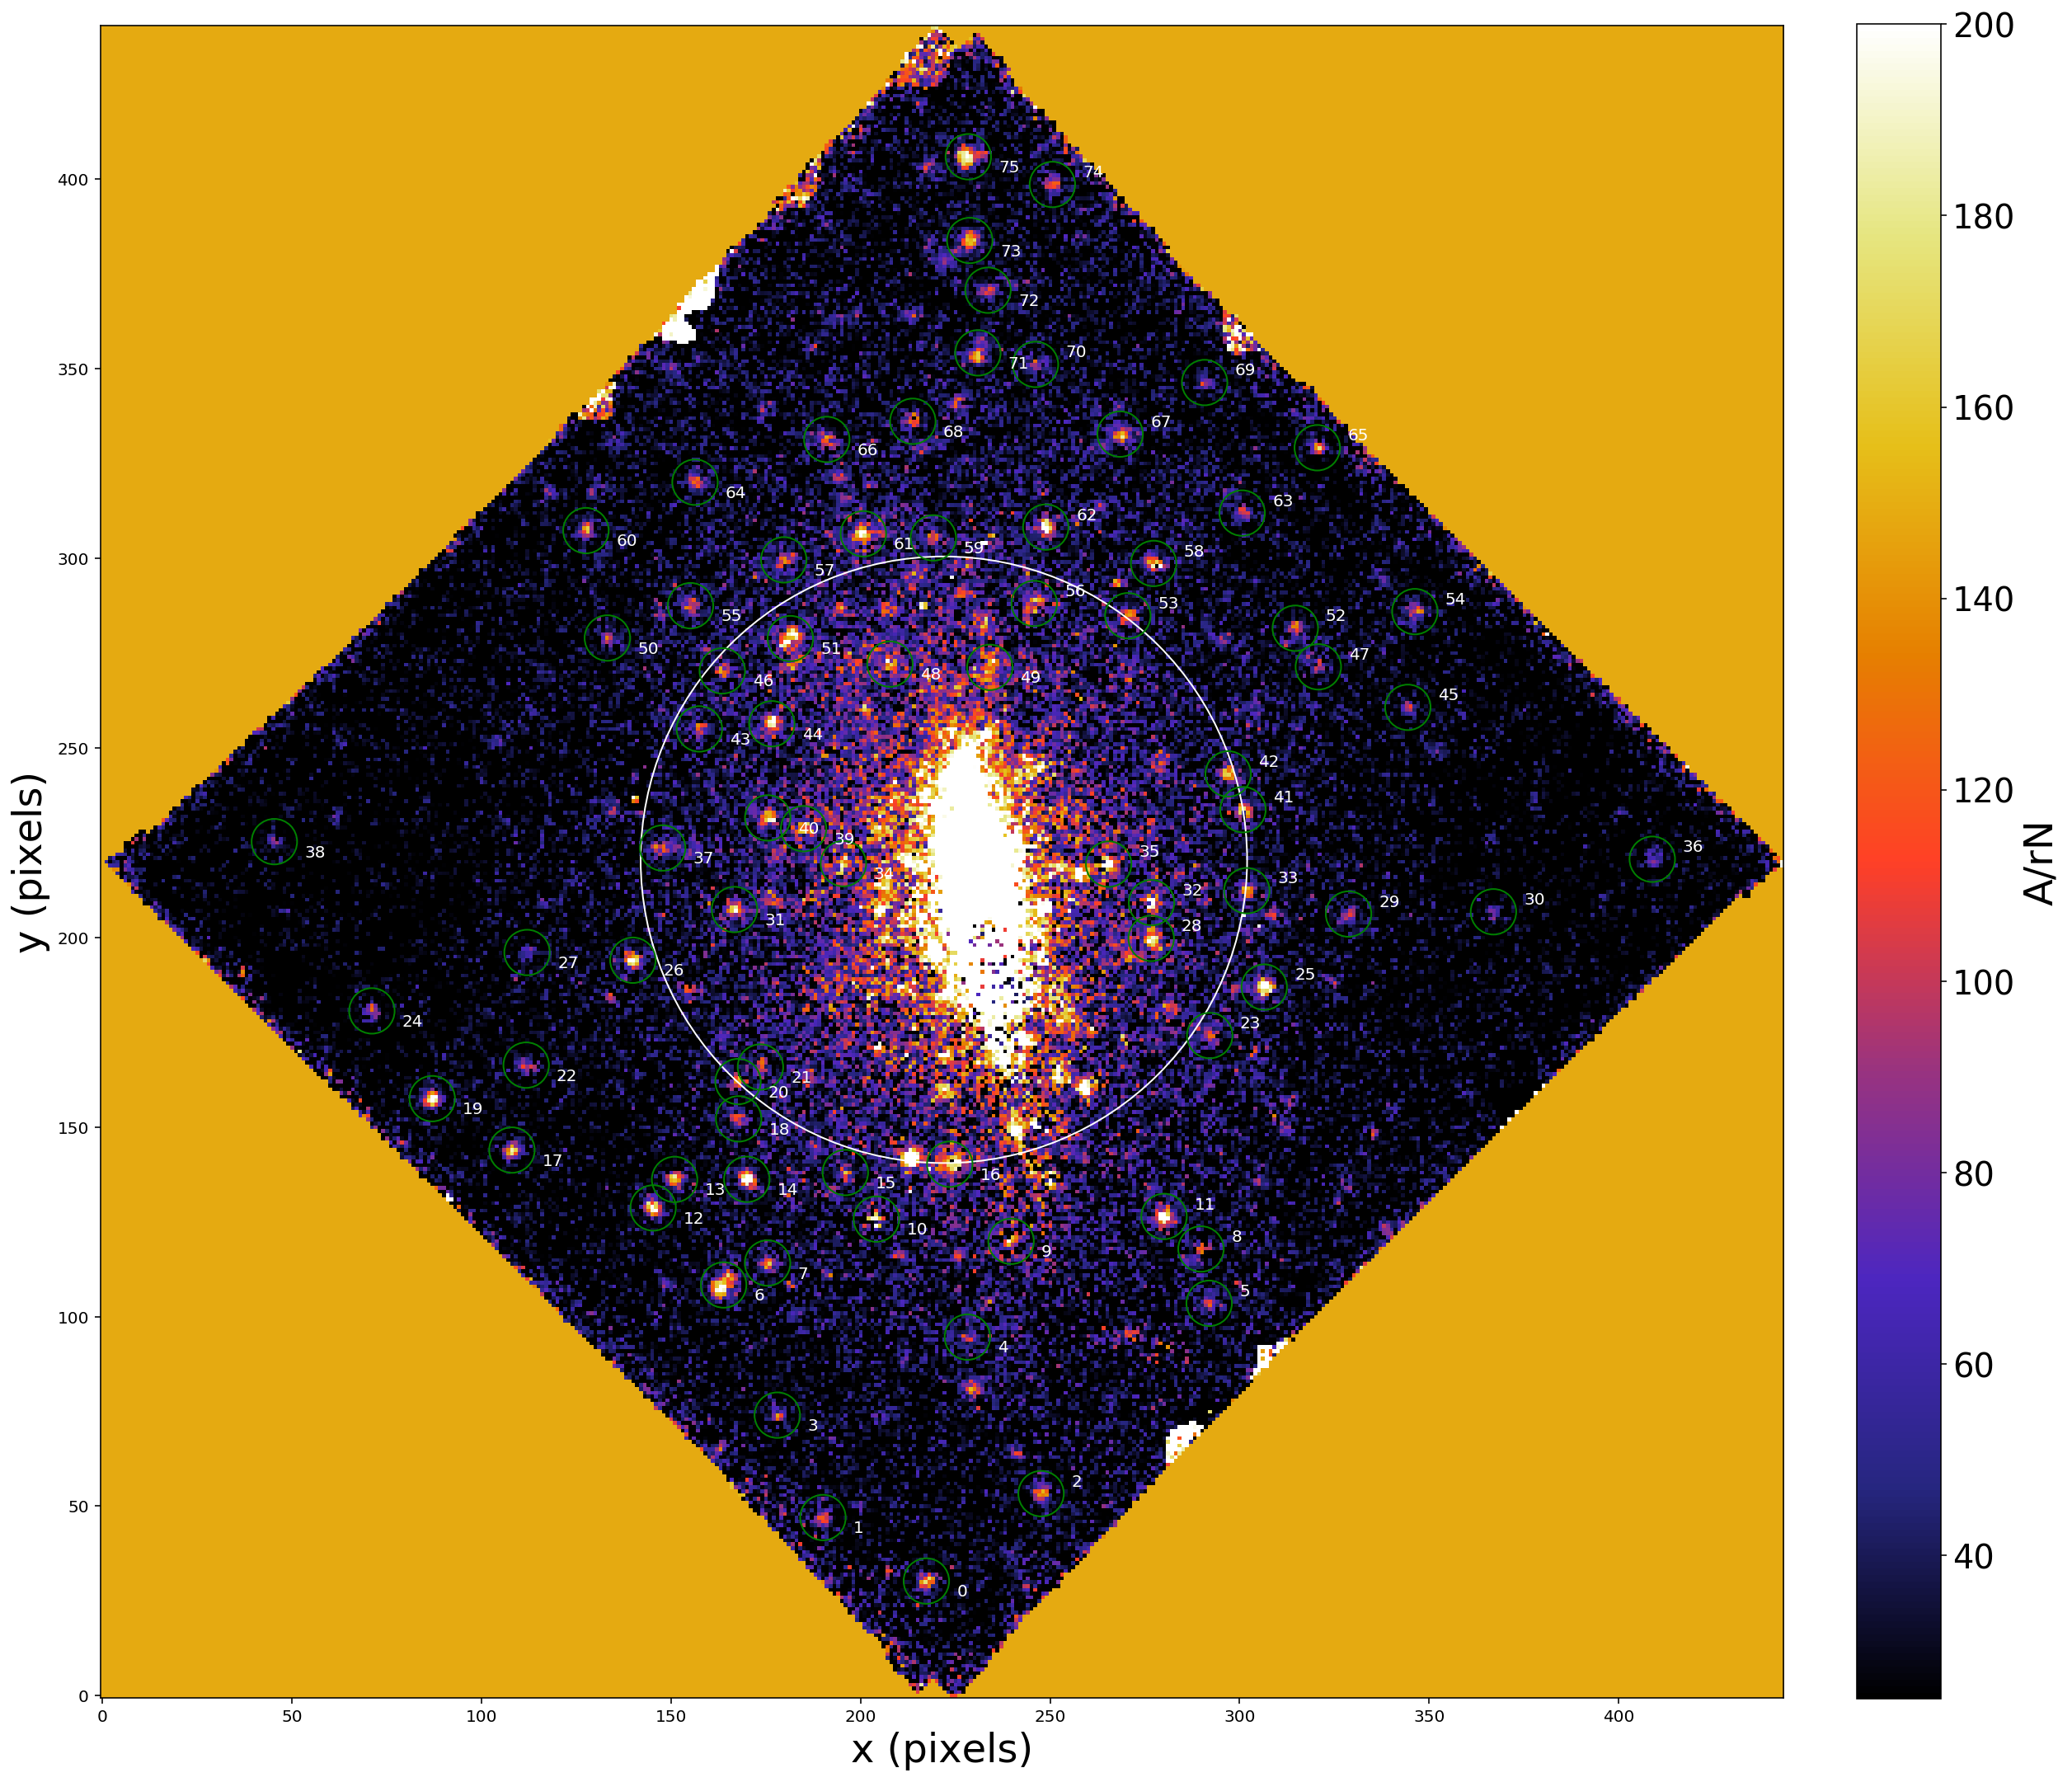

In [38]:
plt.figure(figsize=(20,20))
plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap", vmin=25, vmax=200)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=24)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=20)
plt.xlabel("x (pixels)", fontsize=24)
plt.ylabel("y (pixels)", fontsize=24)
circ_r = plt.Circle((x_data/2.,y_data/2.), 80, color="white", fill=False)
ax.add_artist(circ_r)
for i, item in enumerate(x_y_list):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="green", fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(i, (item[0]+8, item[1]+2), color="white", size=10)

plt.savefig("Plots/FCC167/ArN circled map.png")

# Velocity vs M_{5007}

(-5, 0)

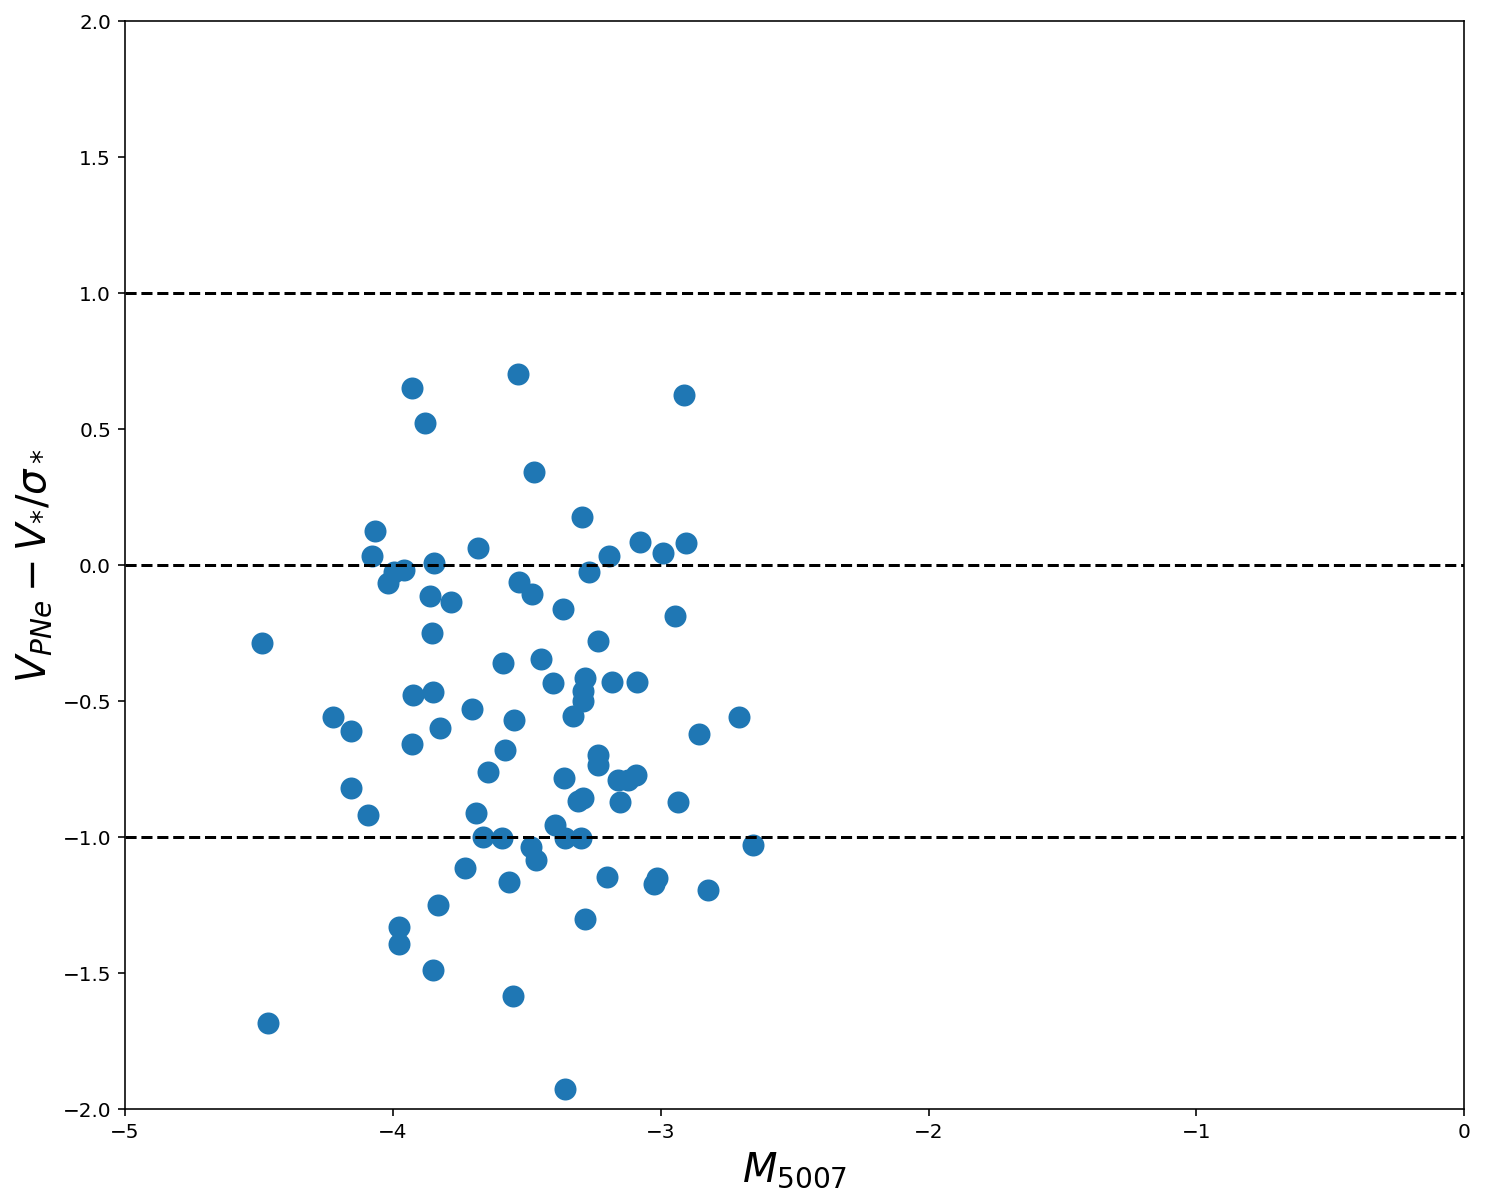

In [15]:
#%% Work on stellar dispersion comparison plot
stellar_vel = 0. # km/s
stellar_dis = 240. # km/s
PNe_vel_ratio = (PNe_df["V (km/s)"].loc[PNe_df["A/rN"]>3.] - stellar_vel)/ stellar_dis

plt.figure(44, figsize=(12,10))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["A/rN"]>3.], PNe_vel_ratio, s=100)
plt.xlabel("$M_{5007}$", fontsize=20)
plt.ylabel("$V_{PNe} - V_{*} / \sigma_*$", fontsize=20)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.ylim(-2,2)
plt.xlim(-5,0)

# MCMC routine


In [147]:
MCMC_df = pd.DataFrame(columns=("PNe number", "Total Flux", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN","stddev", "FWHM", "beta"))
MCMC_df["PNe number"] = np.arange(1,len(x_PNe)+1)

In [148]:
%%time
# Using MCMC from LMFit, with emcee to fit sources, will need work done before running

def lnprob(params, data, error, num):
    noise = params["f"]
    res = MUSE_3D_residual(params, wavelength, x_fit, y_fit, data, error, num, useful_stuff)
    return -0.5 * np.sum((res / noise)**2 + np.log(2 * np.pi * noise**2))

# Use minimization results from above

MCMC_moff_amp = np.zeros(len(x_PNe))
MCMC_gamma = np.zeros(len(x_PNe))
MCMC_beta = np.zeros(len(x_PNe))
MCMC_params = np.zeros((len(x_PNe),10))


# add a noise parameter and run MCMC for each run from results_for_MCMC
for PNe_num in np.arange(26,27):#, len(x_PNe)):
    useful_stuff = []
    run_mini = minimize(MUSE_3D_residual, params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, useful_stuff), nan_policy="propagate")
    mini_result = run_mini
    #add noise parameter
    mini_result.params.add('f', value=1, min=0.001, max=2)
    mini_lnprob = Minimizer(lnprob, mini_result.params, fcn_args=(PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num))
    # Run MCMC routine
    MCMC_results = mini_lnprob.emcee(nwalkers=20, burn=400, steps=1500, thin=8, workers=3, params=mini_result.params)
    # store results
    MCMC_df.loc[PNe_num, "FWHM"] = MCMC_results.params["FWHM"].value
    MCMC_df.loc[PNe_num, "beta"] = MCMC_results.params["beta"].value
    MCMC_df.loc[PNe_num, "stddev"] = MCMC_results.params["Gauss_std"].value
    MCMC_df.loc[PNe_num, "Total Flux"] = useful_stuff[0][0]
    MCMC_df.loc[PNe_num, "V (km/s)"] = (c * (MCMC_results.params["mean"] - 5006.8) / 5006.8) / 1000
    #list_of_best_stddev[PNe_num] = MCMC_results.params["Gauss_std"]
    #list_of_residuals[PNe_num] = useful_stuff[0][1]
    #list_of_A_OIII[PNe_num] = useful_stuff[0][2]
    #list_of_F_OIII_xy[PNe_num] = useful_stuff[0][3]
    #list_of_M_amp[PNe_num] = MCMC_results.params["moffat_amp"]
    #list_of_x[PNe_num] = MCMC_results.params["x_0"]
    #list_of_y[PNe_num] = MCMC_results.params["y_0"]
    #list_of_means[PNe_num] = MCMC_results.params["mean"]
    #list_of_g_bkg[PNe_num] = MCMC_results.params["Gauss_bkg"]
    #list_of_g_grad[PNe_num] = MCMC_results.params["Gauss_grad"]
    #save errors
    #moff_A_err[PNe_num] = results.params["moffat_amp"].stderr
    #x_0_err[PNe_num] = results.params["x_0"].stderr
    #y_0_err[PNe_num] = results.params["y_0"].stderr
    #mean_err[PNe_num] = results.params["mean"].stderr
    #g_bkg_err[PNe_num] = results.params["Gauss_bkg"].stderr
    #g_grad_err[PNe_num] = results.params["Gauss_grad"].stderr
    #h.value += 1
    
A_by_rN = list_of_A_OIII / list_of_residuals
PNe_df["A/rN"] = A_by_rN

def log_10(x):
    return np.log10(x)

MCMC_df["m 5007"] = -2.5 * MCMC_df["Total Flux"].apply(log_10) - 13.74
dM = 31.28 #5. * np.log10(16.4) + 25
MCMC_df["M 5007"] = MCMC_df["m 5007"] - dM

CPU times: user 26.2 s, sys: 5.84 s, total: 32.1 s
Wall time: 3min 23s


# PSF Fitter - Simultaneous fitter

In [90]:
# Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(2, "m 5007").index.values
sel_PNe = [63,26]#[ 28]#, 29]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe] 
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5035.0)    
    
PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
PSF_params.add("beta", value=4.0, min=0.01, max=12., vary=True) 
PSF_params.add("Gauss_FWHM", value=0.00001, min=0.000001, max=3.0, vary=False) # LSF, instrumental resolution.

PSF_results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, np.ones(len(sel_PNe))), nan_policy="propagate")

print("FWHM: ",PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr/PSF_results.params["FWHM"].value)*100) )
print("Beta: ",PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr/PSF_results.params["beta"].value)*100) )
print("Gauss FWHM: ", PSF_results.params["Gauss_FWHM"].value, "+/-", PSF_results.params["Gauss_FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["Gauss_FWHM"].stderr/PSF_results.params["Gauss_FWHM"].value)*100) )
print(report_fit(PSF_results))

[63, 26]
FWHM:  4.040611045506273 +/- 0.12912693935382302 (3.20%)
Beta:  2.9684998563969365 +/- 0.6162866667260687 (20.76%)
Gauss FWHM:  1e-05 +/- 0 (0.00%)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 121
    # data points      = 32786
    # variables        = 14
    chi-square         = 3200854.99
    reduced chi-square = 97.6704195
    Akaike info crit   = 150226.293
    Bayesian info crit = 150343.862
[[Variables]]
    moffat_amp_000:  220.690793 +/- 7.40986725 (3.36%) (init = 200)
    x_000:           6.18829339 +/- 0.07136123 (1.15%) (init = 6.5)
    y_000:           5.82203614 +/- 0.07368557 (1.27%) (init = 6.5)
    mean_000:        5032.34106 +/- 0.04146715 (0.00%) (init = 5035)
    gauss_bkg_000:  -0.01021983 +/- 0.00211488 (20.69%) (init = 0.001)
    gauss_grad_000:  51.4617482 +/- 10.5946184 (20.59%) (init = 0.001)
    moffat_amp_001:  245.191466 +/- 7.59430957 (3.10%) (init = 200)
    x_001:           5.99053702 +/- 0.06140189 (1.02%) (init =

# PSF fitting evaluation over individual fittings

In [26]:
num_psf = len(x_PNe)
n_brightest = PNe_df.nlargest(num_psf, "A/rN").index.values
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
rad_sel = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)

#params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=4990., max=5060.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.00001)


for i in np.arange(0, num_psf):
    sel_PNe = [n_brightest[i]]
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = obj_error_cube[sel_PNe]
    PSF_params = Parameters()
    model_params(p=PSF_params, n=0, amp=100.0, mean=5035.0)
    PSF_params.add('FWHM', value=2.0, min=0.001, max=8., vary=True)
    PSF_params.add("beta", value=4.0, min=0.001, max=8., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0001, min=0.0000001, max=5.0, vary=False)
    rad_sel[i] = PNe_df.iloc[sel_PNe]["rad D"]
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, [1.]), nan_policy="propagate")
    fitted_FWHM[i] = results.params["FWHM"].value
    fitted_beta[i] = results.params["beta"].value
    fitted_G_FWHM[i] = results.params["Gauss_FWHM"].value
    


In [31]:
def straight_res(params, x, data):
    m = params["m"]
    c = params["c"]
    y = m*x + c
    return data - y

straight_params = Parameters()
straight_params.add("m", value=0.1)
straight_params.add("c", value=0.1)

straight_results = minimize(straight_res, straight_params, args=(rad_sel, fitted_beta))
m = straight_results.params["m"].value
c = straight_results.params["c"].value
report_fit(straight_results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 76
    # variables        = 2
    chi-square         = 348.991549
    reduced chi-square = 4.71610201
    Akaike info crit   = 119.847892
    Bayesian info crit = 124.509358
[[Variables]]
    m:  0.00694877 +/- 0.00650964 (93.68%) (init = 0.1)
    c:  1.40923340 +/- 0.74487047 (52.86%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, c) = -0.942


1.5642593355827343
3.417222714122117


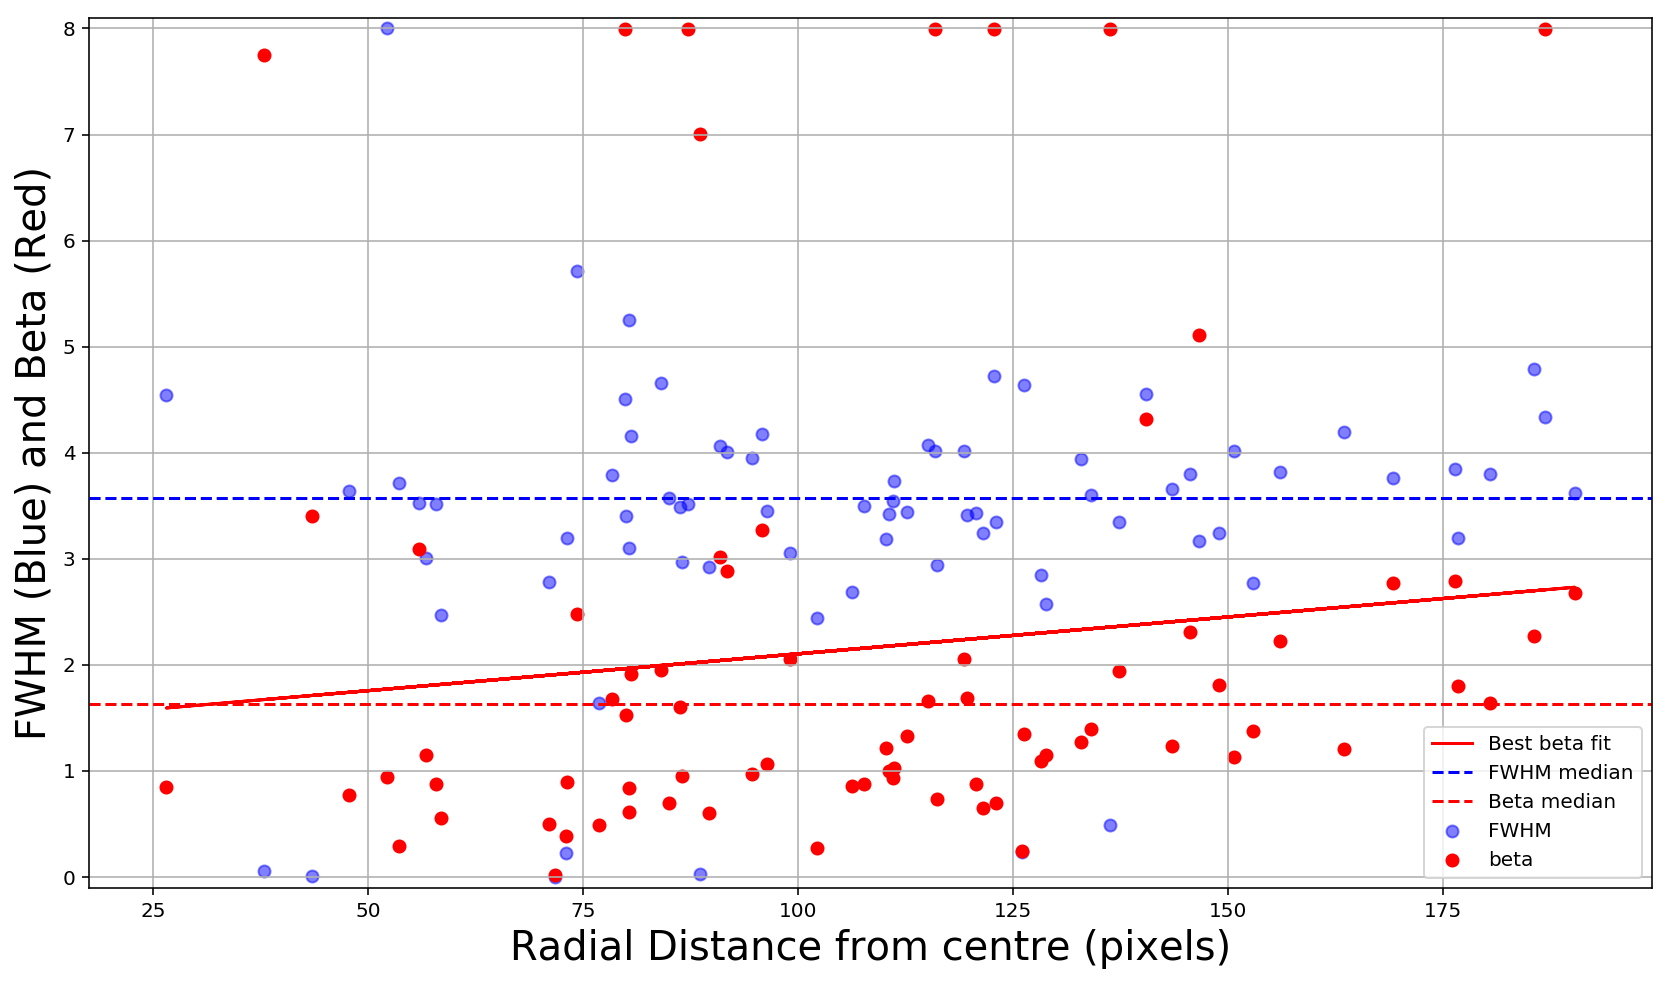

In [34]:
plt.figure(figsize=(14,8))
plt.scatter(rad_sel, fitted_FWHM, label="FWHM", c="blue", alpha=0.5)
plt.scatter(rad_sel, fitted_beta, label="beta", c="red")
plt.plot(rad_sel, (m*rad_sel + c), label="Best beta fit", c="r")
#plt.scatter(rad_sel, fitted_G_FWHM, label="G_FWHM", c="k" )
plt.xlabel("Radial Distance from centre (pixels)", fontsize=20)
plt.ylabel("FWHM (Blue) and Beta (Red)", fontsize=20)
plt.ylim(-0.1,8.1)
plt.grid()

plt.axhline(np.median(fitted_FWHM[:50]), label="FWHM median", ls="dashed", c="blue")
plt.axhline(np.median(fitted_beta[:50]), label="Beta median", ls="dashed", c="red")
#plt.axhline(np.median(fitted_G_FWHM), label="G_FWHM median", ls="dashed", c="k")

print(np.median(fitted_beta[:20]))
print(np.median(fitted_FWHM[:20]))
plt.legend()
plt.savefig("Plots/FCC167/radial_FWHM_beta.png")

# PSF Fitting - Evaluation with differing number of simultaneous PNe fitted

In [18]:
num_psf=10
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
A_rN_total = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)
fitted_moff_amp = [[]]*num_psf
fitted_x = [[]]*num_psf
fitted_y = [[]]*num_psf

#params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.01)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.01)
    
for j in np.arange(0, num_psf):
    sel_PNe = PNe_df.nlargest(j+1, "A/rN").index.values
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = obj_error_cube[sel_PNe]
    PSF_params = Parameters()
    for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5035.0)
    PSF_params.add('FWHM', value=3.8, min=0.01, max=12., vary=False)
    PSF_params.add("beta", value=3.0, min=0.01, max=12., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0001, min=0.00001, max=3.0, vary=False)
    A_rN_total[j] = np.sqrt(np.sum(PNe_df.iloc[sel_PNe]["A/rN"]**2.))
    A_rN_of_PNe = np.ones(len(sel_PNe))#PNe_df.iloc[sel_PNe]["A/rN"].values
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, A_rN_of_PNe), nan_policy="propagate")#, method="differential_evolution")
    fitted_FWHM[j] = results.params["FWHM"].value
    fitted_beta[j] = results.params["beta"].value
    fitted_G_FWHM[j] = results.params["Gauss_FWHM"].value
    #for k in np.arange(0, len(sel_PNe)):
    #    fitted_moff_amp.append(results.params["moffat_amp_{:03d}".format(k)].value)
    #    fitted_x.append(results.params["x_{:03d}".format(k)].value)
    #    fitted_y.append(results.params["y_{:03d}".format(k)].value)

    

3.8
1.37908560862


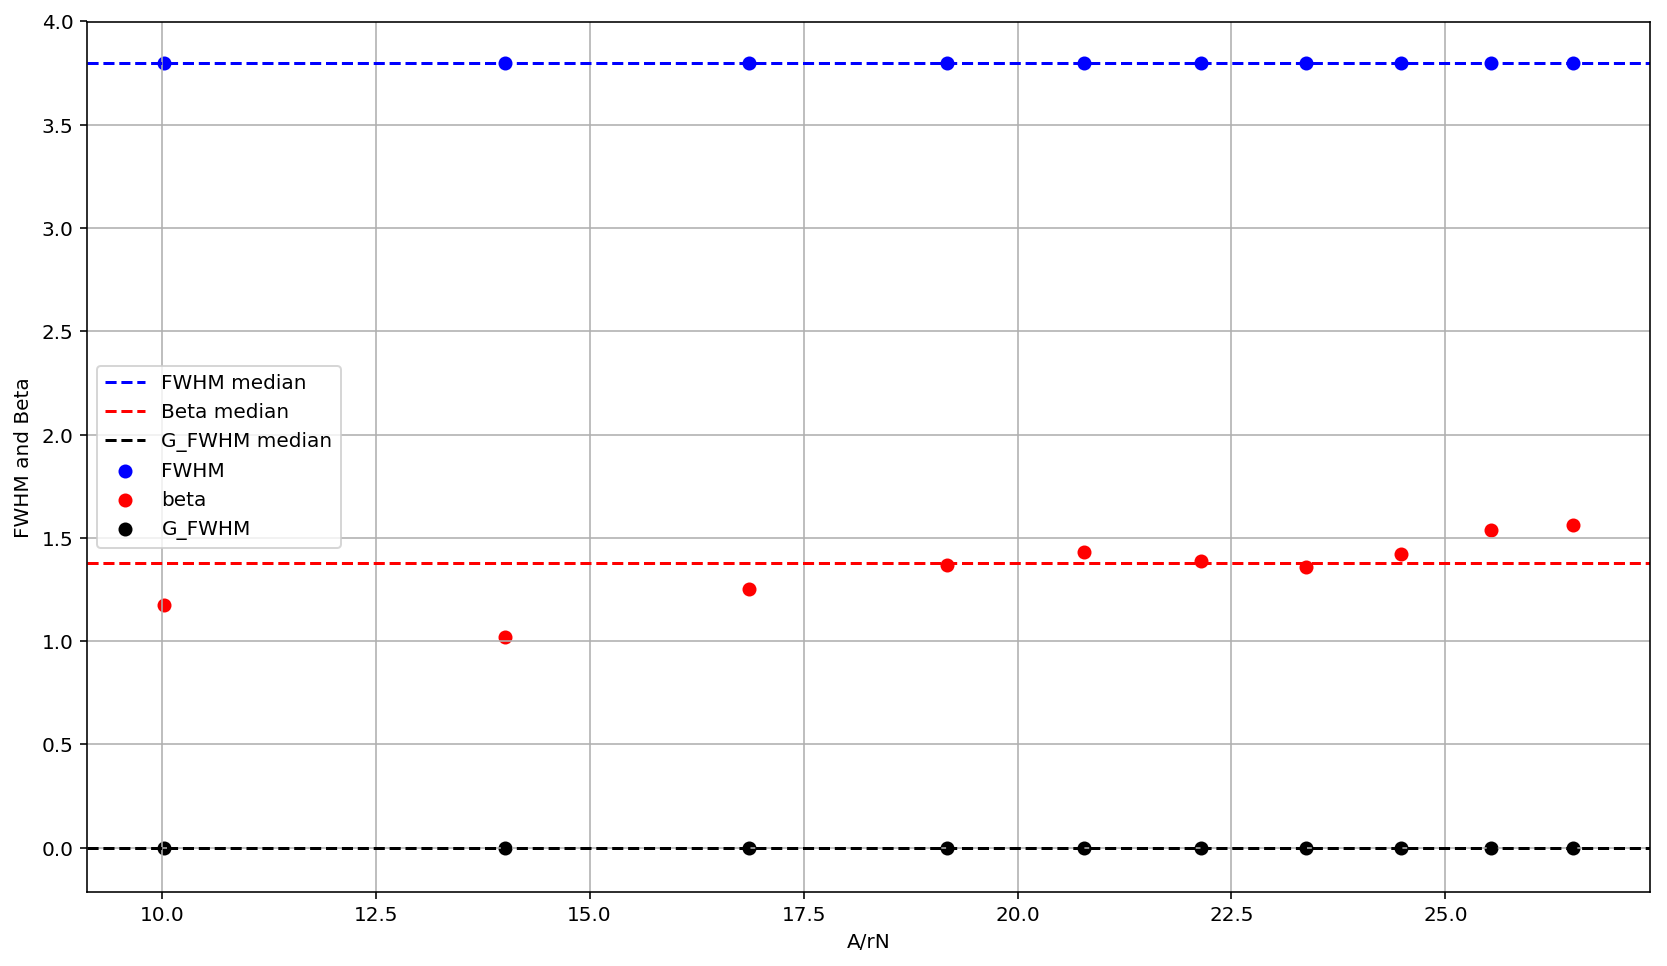

In [19]:
plt.figure(figsize=(14,8))
plt.scatter(A_rN_total, fitted_FWHM, label="FWHM", c="blue")
plt.scatter(A_rN_total, fitted_beta, label="beta", c="red")
plt.scatter(A_rN_total, fitted_G_FWHM, label="G_FWHM", c="k" )
plt.xlabel("A/rN")
plt.ylabel("FWHM and Beta")
plt.grid()

plt.axhline(np.median(fitted_FWHM[:]), label="FWHM median", ls="dashed", c="blue")
plt.axhline(np.median(fitted_beta[:]), label="Beta median", ls="dashed", c="red")
plt.axhline(np.median(fitted_G_FWHM[:]), label="G_FWHM median", ls="dashed", c="k")

print(np.median(fitted_FWHM[:]))
print(np.median(fitted_beta[:]))
      
plt.legend()
#plt.savefig("Plots/FCC167/PSF_A_rN_FWHM_beta.png")

# MCMC PSF fitter

In [46]:
# MCMC
sel_PNe = [25]# PNe_df.nlargest(1, "A/rN").index.values

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = error_cube[sel_PNe] 

PSF_params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001)

for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=100.0, mean=5035.0)   
    
PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
PSF_params.add("beta", value=4.0, min=0.01, max=12., vary=True) 
PSF_params.add("Gauss_FWHM", value=0.00001, min=0.0000001, max=3.0, vary=False) # LSF, instrumental resolution.

def lnprob(p, data, error):
    noise = p["f"]
    res = PSF_residuals(p, wavelength, x_fit, y_fit, data, error, PNe_df.loc[sel_PNe, "A/rN"].values)
    return -0.5 * np.sum((res / noise)**2 + np.log(2 * np.pi * noise**2))

# add a noise parameter and run MCMC for each run from results_for_MCMC
run_mini = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, PNe_df.loc[sel_PNe, "A/rN"].values), nan_policy="propagate")
print("Initial fit complete.")
#add noise parameter
run_mini.params.add('f', value=1., min=0.001, max=2.)
print("Nuisance Parameter added.")
mini_lnprob = Minimizer(lnprob, run_mini.params, fcn_args=(selected_PNe, selected_PNe_err))
print("Minimizer ready.")
# Run MCMC routine
print("All aboard the MCMC train.")
MCMC_results = mini_lnprob.emcee(nwalkers=400, burn=1000, steps=3000, thin=20, workers=6, is_weighted=True, params=run_mini.params)

print("FWHM: " , MCMC_results.params["FWHM"].value, MCMC_results.params["FWHM"].stderr)
print("Beta: " , MCMC_results.params["beta"].value, MCMC_results.params["beta"].stderr)

Initial fit complete.
Nuisance Parameter added.
Minimizer ready.
All aboard the MCMC train.


Process ForkPoolWorker-8:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:


emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-9:
Process ForkPoolWorker-10:


  params: [ 2.53787022e+02  6.03147079e+00  5.40578349e+00  5.03571881e+03
 -5.11829382e-03  2.57319224e+01  3.77611267e+00  2.39934126e+00
  1.99999702e+00]
  args: (<function lnprob at 0x7f6b03ac5488>, Parameters([('moffat_amp_000', <Parameter 'moffat_amp_000', 253.78702182957582, bounds=[0.001:inf]>), ('x_000', <Parameter 'x_000', 6.031470788277317, bounds=[0.001:13]>), ('y_000', <Parameter 'y_000', 5.405783488394535, bounds=[0.001:13]>), ('mean_000', <Parameter 'mean_000', 5035.718809309787, bounds=[5000.0:5070.0]>), ('gauss_bkg_000', <Parameter 'gauss_bkg_000', -0.005118293816811861, bounds=[-inf:inf]>), ('gauss_grad_000', <Parameter 'gauss_grad_000', 25.73192242219885, bounds=[-inf:inf]>), ('FWHM', <Parameter 'FWHM', 3.776112665854742, bounds=[0.01:12.0]>), ('beta', <Parameter 'beta', 2.399341262507234, bounds=[0.01:12.0]>), ('Gauss_FWHM', <Parameter 'Gauss_FWHM', value=1e-05 (fixed), bounds=[1e-07:3.0]>), ('f', <Parameter 'f', 1.9999970196989536, bounds=[0.001:2.0]>)]), ['moffat

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/local/tspriggs/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/local/tspriggs/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/local/tspriggs/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/local/tspriggs/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/local/tspriggs/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/local/tspriggs/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/local/tspriggs/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    se

KeyboardInterrupt: 

  File "<ipython-input-46-a2a7f08a9a97>", line 25, in lnprob
    res = PSF_residuals(p, wavelength, x_fit, y_fit, data, error, PNe_df.loc[sel_PNe, "A/rN"].values)
  File "/auto/data/tspriggs/Github/MUSE_PNe_fitting/MUSE_Models.py", line 106, in PSF_residuals
    FWHM, beta, Gauss_FWHM, PSF_params["gauss_grad_{:03d}".format(k)], PSF_params["gauss_bkg_{:03d}".format(k)], PSF_params["mean_{:03d}".format(k)])
  File "/auto/data/tspriggs/Github/MUSE_PNe_fitting/MUSE_Models.py", line 99, in generate_model
    (np.abs(Amp)/3.) * np.exp(- 0.5 * (l - (mean - 47.9399))** 2. / Gauss_std**2.)) for Amp in A_OIII_xy]
  File "/auto/data/tspriggs/Github/MUSE_PNe_fitting/MUSE_Models.py", line 99, in <listcomp>
    (np.abs(Amp)/3.) * np.exp(- 0.5 * (l - (mean - 47.9399))** 2. / Gauss_std**2.)) for Amp in A_OIII_xy]
  File "/local/tspriggs/miniconda3/lib/python3.6/site-packages/lmfit/parameter.py", line 833, in __array__
    def __array__(self):
KeyboardInterrupt
Process ForkPoolWorker-7:
Traceback (most

In [ ]:
report_fit(MCMC_results)